# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
### **Table of Contents**

- [0.0 Introduction](#heading_identifier_0)
- [1.0 Data Overview](#heading_identifier_1)
- [2.0 Cleaning and Merging Datasets](#heading_identifier_2)
  - Initial Feature Selection
  - Matching Census Tracts
  - Cleaning
  - Merging
- 3.0 EDA


---
**<center><h2 id="heading_identifier_0">Inroduction</h2>**


<h2> Introduction to this Notebook 



Cook County Income Dataset</br>
The purpose of this notebook is to understand, clean and conduct initial EDA of Income Dataset. </br>
The dataset was downloaded from US Census Bureau, which can be accessed using the following link [US Census Bureau Link](https://data.census.gov/).

---
**<center><h2 id="heading_identifier_1">Data Overview</h2>**

In [1]:
#import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
#os to load files
import os
import re

#load all custom functions
from functions import *

<h2>Importing Data

In [2]:
#Define folder path
rel_folder_path='../data/raw/income'

#Create a list containing the names of all csv files in the folder (there are 11 csv files containing data from each year between 2010 and 2011)
income_csv_files = [f for f in os.listdir(rel_folder_path) if f.endswith('.csv')]

#instantiate an empty list to store all the dataframes obtain from csv files
income_all=[]

#loop through each csv file name in the list and load each file as a pandas dataframe
for file in income_csv_files:
    filepath = os.path.join(rel_folder_path, file)
    df = pd.read_csv(filepath)
    income_all.append(df)

In [3]:
#Retrieve the name of the first csv file to check the order of the dataframes
income_csv_files[0]

'ACSST5Y2010.S1901-Data.csv'

* As expected, the name of the first csv file was 'ACSST5Y`2010`.S1901-Data.csv', which contains income data from 2010
* The first item in the list contains data for 2010 and the last item contains data for 2021

* Confirm that list items are pandas dataframes

In [4]:
#check the type of the first item in the list
type(income_all[0])

pandas.core.frame.DataFrame

* Preview data in one of the dataframes

In [5]:
#preview the top 5 rows of the first dataframe by accessing the first item [0] in the list
income_all[0].head()

,GEO_ID,NAME,S1901_C01_001E,S1901_C01_001EA,S1901_C01_001M,S1901_C01_001MA,S1901_C02_001E,S1901_C02_001M,S1901_C02_001EA,S1901_C02_001MA,...,S1901_C02_016MA,S1901_C03_016E,S1901_C03_016M,S1901_C03_016EA,S1901_C03_016MA,S1901_C04_016E,S1901_C04_016M,S1901_C04_016EA,S1901_C04_016MA,Unnamed: 258
0,Geography,Geographic Area Name,Households!!Estimate!!Total,Annotation of Households!!Estimate!!Total,Households!!Margin of Error!!Total,Annotation of Households!!Margin of Error!!Total,Families!!Estimate!!Total,Families!!Margin of Error!!Total,Annotation of Families!!Estimate!!Total,Annotation of Families!!Margin of Error!!Total,...,Annotation of Families!!Margin of Error!!PERCE...,Married-couple families!!Estimate!!PERCENT IMP...,Married-couple families!!Margin of Error!!PERC...,Annotation of Married-couple families!!Estimat...,Annotation of Married-couple families!!Margin ...,Nonfamily households!!Estimate!!PERCENT IMPUTE...,Nonfamily households!!Margin of Error!!PERCENT...,Annotation of Nonfamily households!!Estimate!!...,Annotation of Nonfamily households!!Margin of ...,NaN
1,1400000US17031010100,"Census Tract 101, Cook County, Illinois",2149,NaN,147,NaN,1051,216,NaN,NaN,...,(X),(X),-888888888,(X),(X),20.9,(X),NaN,(X),NaN
2,1400000US17031010201,"Census Tract 102.01, Cook County, Illinois",2475,NaN,201,NaN,1150,205,NaN,NaN,...,(X),(X),-888888888,(X),(X),32.5,(X),NaN,(X),NaN
3,1400000US17031010202,"Census Tract 102.02, Cook County, Illinois",1133,NaN,108,NaN,663,157,NaN,NaN,...,(X),(X),-888888888,(X),(X),30.6,(X),NaN,(X),NaN
4,1400000US17031010300,"Census Tract 103, Cook County, Illinois",2750,NaN,219,NaN,1314,234,NaN,NaN,...,(X),(X),-888888888,(X),(X),23.1,(X),NaN,(X),NaN


* First row [0] contains further column explanations
* Each subsequent row is a unique census tract
* Each column contains census information about each census tract

In [6]:
income_all[0].shape

(1320, 259)

* The first dataframe (year 2010) has 1320 rows (1319 census tracts) and 259 features

In [7]:
income_all[-1].shape

(1333, 259)

* The last dataframe (year 2021) has 1333 rows (1332 census tracts) and 259 features
* Note the number of distinct census tracts increased from 1320 to 1333 between the years of 2010 and 2021
  * This means new census tracts were added

</br></br></br>

---
**<center><h2 id="heading_identifier_2">CLEANING AND MERGING DATASETS</h2>**

This section contains 4 subsections:
* Initial Feature Selection
* Marching Census Tracts
* Cleaning
* Merging

[Note] : The datasets will be concatenated on census tracts. Hence, before attempting to merge, census tracts should be standardized between the years.


<h2>Initial Feature Selection</h2>

Following review of the dataframes, it was indentified that the following columns are of interest to the study : 
* **'GEO_ID'** : contains `Census_Tract`
* **S1901_C01_013E** : contains `Mean_Income`
* **S1901_C01_012E** : contains `Median_Income`
* **S1901_C01_001E** : contains `Household_Count`

Create a following dictionary **`{column name: column description}`** which will be used to select and rename the columns of interest

In [8]:
#create dictionary
col_di={'GEO_ID':'Census_Tract','S1901_C01_013E':'Mean_Income','S1901_C01_012E':'Median_Income','S1901_C01_001E':'Household_Count'}

Define a function to help clean dataframes & select and rename relevant columns

In [9]:
#this function will only be used in this notebook, hence, defined locally

def census_column_selector(df,di,remove_first_row=False):
    '''
    Use:
        This function selects columns speicified by the dictory keys and renames the columns to the dictionary values

    Input:
        df (pandas.DataFrame): The input DataFrame to select columns from.
        col_di (dict): A dictionary with column names as keys and new names as values.
        remove_first_row (bool): Optional flag to remove the first row of the DataFrame. Default is False.
        
    Returns:
        pandas.DataFrame: A new DataFrame containing only the selected columns and renamed columns.    
    '''

    #copy dataframe to avoid overwritting the original
    df_temp=df.copy()

    #remove first row if required
    if remove_first_row==True:
        df_temp=df_temp.iloc[1:,:]

    # extract last 6 characters of GEO_ID column (last 6 char=census tract number)
    df_temp['GEO_ID']=df_temp['GEO_ID'].str[-6:]

    #select columns using dictionary 'di' keys and rename using the same dictionary
    df_temp=df_temp[di.keys()].rename(columns=di)

    # convert selected columns to numeric data type
    df_temp = df_temp.apply(pd.to_numeric, errors='coerce')
    # if data is missing or non-numeric, (errors='coerce') converts it to nan

    # convert 0 and 0.0 values to NaNs
    df_temp.replace({0.0:np.nan,0:np.nan},inplace=True)

    return df_temp

Select the columns of interest and remove the fisrt row for all of the downloaded dataframes

In [10]:
#use list comprehension to apply the function census_column_selector to each DataFrame in the list income_all
#set remove_first_row to True to remove the fisrt row [0] as it contains column description not the actual data
income_all_temp=[census_column_selector(df,col_di,remove_first_row=True) for df in income_all]

Confirm the results:


* Overview of the first income dataframe (from year : 2010)

In [11]:
#overview is a custom function defined in functions.py file to help with high level dataframe overview
overview (income_all_temp[0])

The dataframe shape is (1319, 4)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int64,0,0.000000,10100.0,990000.0,260600.0
Mean_Income,float64,5,0.379075,51153.0,NaN,35739.0
Median_Income,float64,6,0.454890,36905.0,NaN,22727.0
Household_Count,float64,5,0.379075,2149.0,NaN,872.0


* Overview of the last income dataframe (from year : 2021)

In [12]:
overview (income_all_temp[-1])

The dataframe shape is (1332, 4)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int64,0,0.000000,10100.0,990000.0,830006.0
Mean_Income,float64,4,0.300300,69746.0,NaN,55897.0
Median_Income,float64,19,1.426426,60316.0,NaN,NaN
Household_Count,float64,4,0.300300,2411.0,NaN,1252.0


* Each dataframe contains some missing values for Income and Household Count Columns. There are no missing values for census_tract
* In particualr, the tails of both dataframes (last census tracts) contain many null values 
* Given that the Income Dataframes are for whole of Cook County and not only for Chicago, it is possible that the census tracts needed for this project do not have nay missing values

</br>
</br>

---
<h2 id="heading_identifier_2">Matching Census Tracts</h2>

* The purpose of this subsection is to ensure 
  * a) that census tracts from the Income Dataset match all the Planning Application census tracts
  * b) census tract numbers match between the years

In [234]:
ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

,CENSUS_TRACT,LATITUDE,LONGITUDE
0,10100,42.021004,-87.669351
1,10201,42.016344,-87.679624
2,10202,42.016615,-87.673653
3,10300,42.016164,-87.666474
4,10400,42.001935,-87.659335
...,...,...,...
804,843900,41.774995,-87.581733
805,844600,41.813559,-87.624404
806,844700,41.853928,-87.711570
807,980000,41.977366,-87.895152


In [235]:
#Load a dataframe with all the census tracts and their respective coordiantes from the current Permit Dataframe
ct_coord=joblib.load('../data/interim/ct_coord.pkl').reset_index(drop=True)

ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

permit_tracts=set(ct_coord['CENSUS_TRACT'])


**A) Comparing Census Tracts from the Permit Database and the Income Database**

* Check if 2021 census tracts contain data for all census tracts in the permit dataset

In [14]:
x=len(permit_tracts.difference(set(income_all_temp[-1]['Census_Tract'])))
print('Number of planning ct not present in Income from 2021 is',x)

Number of planning ct not present in Income from 2021 is 0


All census tracts from Planning Dataset are explained by the census tracts from 2021 Income Dataset

* Check if 2010 census tracts contain data for all census tracts in the permit dataset

In [15]:
x=len(permit_tracts.difference(set(income_all_temp[0]['Census_Tract'])))
print('Number of planning ct not present in Income from 2010 is',x)

Number of planning ct not present in Income from 2010 is 12


This mismatch is likely caused by census tract notation changing between the years

</br>


**B) Comparing Census Tracts between the years**

* Check the difference between census tracts in 2010 and 2021
* Check how many of those different are also present in planning applications 
  * Changes are only relevant to the project if they are also in the planning dataset

In [16]:
#using sets find tracts in 2021 that are missing from 2010
difference=set(income_all_temp[-2]['Census_Tract']).symmetric_difference(set(income_all_temp[0]['Census_Tract']))
#print the length of the difference set
print('number of tracts different between 2010 and 2021 is ',len(difference))

#find the intersection between the set of permit_tracts and the difference between 2011 to 2011
relevant_difference=difference & set(permit_tracts)
print('the number of changed tracts relevant to the project is ',len(relevant_difference))

number of tracts different between 2010 and 2021 is  75
the number of changed tracts relevant to the project is  12


* preview the set of census tracts different between 2010 and 2021 that are also present in the permit dataset

In [17]:
#print the set
print(relevant_difference)

{460800, 320101, 320102, 630600, 612200, 380600, 490200, 330101, 330102, 330103, 844600, 844700}


* manually create a dictionary to change census tracts to match between the years
* it was chosen to revert back to lower geograhic density
  * if a tract was split into 2, older ct number will be used
  * if 2 tracts was merged together, newer ct will be used
* the folloing [resource](https://www.esri.com/arcgis-blog/products/arcgis-living-atlas/mapping/acs-2016-2020-updated-boundaries/) was used to define the changes betwen 2010 and 2021

In [18]:
#create a dictionary to match all the rellevant census tracts between the years
tract_changes={
            #new_to_old
            320101:320100,320102:320100,
            330101:330100,330102:330100,330103:330100,

            #old_to_new
            835900:380600,380700:380600,
            490300:490200,490400:490200,
            460700:460800,460600:460800,
            611000:612200,
            630200:630600,630100:630600,
            380700:844600,835700:844600,
            841400:844700,841600:844700}

* map the dictionary to all the income dataframes 

In [19]:
#loop through all dataframes and apply the conversion as defined above
for df in income_all_temp:
    df['Census_Tract'].replace(tract_changes,inplace=True)

* [Note] the same dictionary will have to be mapped onto the planning applications

In [20]:
#  * export the dictionary to then be mapped to the planning application dataframe
joblib.dump(tract_changes, '../data/interim/tract_changes.pkl')

#using a get method, locally replace permit_tracts based on tract_changes dictionary
permit_tracts_updated = [tract_changes.get(item, item) for item in permit_tracts]

* Check if all ct numbers are now matched

In [21]:
missing_2021=set(permit_tracts_updated).difference(set(income_all_temp[-1]['Census_Tract']))
print('Number of census tracts not matched to 2021 Income Dataset - ',len(missing_2021))

missing_2010=set(permit_tracts_updated).difference(set(income_all_temp[0]['Census_Tract']))
print('Number of census tracts not matched to 2010 Income Dataset - ',len(missing_2010))

Number of census tracts not matched to 2021 Income Dataset -  0
Number of census tracts not matched to 2010 Income Dataset -  0


---
<h2 id="heading_identifier">Cleaning</h2>

Required cleaning steps:
* replace ct numbers based on the dictionary `tract_changes` which can be described as {old ct : new ct}
  * [Note] : after replacing the ct numbers, some rows might have the same ct number
  * this can be addressed by merging rows together
* merge rows with the same ct numbers by averaging the Income Data and summing Household Count
* select rows with census tracts that are also present in `permit_tracts` (ct number in the planning dataset)


[Note 1] : these steps will be writted as a function because they have to be applied to all the dataframes in the list </br>
[Note 2] : ct stands for census tract

In [22]:
def census_tract_cleaning(df,di_conversion,relevant):

    '''
    Use:
        Clean Census Income Dataset: replace ct numbers, merge rows with the same ct and select relevant rows
    Inputs:
        df (pandas.DataFrame): The input DataFrame to clean
        di_conversion (dict): A dictionary to update ct numbers
        relevant (list) : A list of planning application ct numbers
    Returns:
        pandas.DataFrame: A new cleaned DataFrame
    '''

    #replace census tracts
    df['Census_Tract']=df['Census_Tract'].replace(di_conversion)

    #merge rows with the same ct
    df=pd.concat([
        #for the same ct, average all columns
        df.drop(columns='Household_Count').groupby('Census_Tract').mean(),\
        #for the same ct, sum household counts
        df.groupby('Census_Tract')['Household_Count'].sum()]\
        #reset index to set ct back as a column
        ,axis=1).reset_index()

    #select only rows in a list `relevant` & reset index
    df=df[df['Census_Tract'].isin(relevant)].reset_index(drop=True)

    #replace any zeros with nan
    df=df.replace({0:np.nan,0.0:np.nan})

    return df

* apply the cleaning steps outlined above

In [23]:
#Apply the function inside a list comperhension
income_all_temp2=[census_tract_cleaning(df,tract_changes,permit_tracts_updated) for df in income_all_temp]

* check that all census tracts match now

In [24]:
#use symmetric difference between two sets
len(set(income_all_temp2[0]['Census_Tract']).symmetric_difference(set(income_all_temp2[-1]['Census_Tract'])))

0

In [25]:
#overview 2010 income dataframe in the format ready to be merged with other dataframes
income_all_temp2[0].head()

,Census_Tract,Mean_Income,Median_Income,Household_Count
0,10100,51153.0,36905.0,2149.0
1,10201,52591.0,40681.0,2475.0
2,10202,47699.0,35724.0,1133.0
3,10300,57075.0,45224.0,2750.0
4,10400,58457.0,44018.0,1943.0


---
<h2 id="heading_identifier">Merge</h2>

**Let's merge dataframes from all years into one dataframe**

* Step 1: Add year suffix to each column apart from census_tract

In [26]:
# Create an empty list to store the DataFrames with year suffices added to the columns
income_all_new=[]

# Set the initial year to 2010
year=2010
# Loop through each DataFrame in income_all_temp2
for df in income_all_temp2:
    # Extract the 'Census_Tract' column and concatenate it with the other columns, which are suffixed with the current year
    # The resulting DataFrame is appended to the income_all_new list
    income_all_new.append(pd.concat([df['Census_Tract'],df.drop(columns='Census_Tract').add_suffix('_').add_suffix(str(year))],axis=1))
    #Increment Year
    year+=1

* Before concating, check if Census Tract Columns Align in all data frames
* Alternatively, merge could be performed

In [27]:
# Extract the 'Census_Tract' column from the first DataFrame in income_all_new
test_col=income_all_new[0]['Census_Tract']

# Loop through each DataFrame in income_all_new
for df in income_all_new:
    # Check if all values in the 'Census_Tract' column of the current DataFrame match those of the first DataFrame
    if all(df['Census_Tract']==income_all_new[0]['Census_Tract']):
        print('EQUAL')
    else:
        print('ERROR')

EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL


* All Census Tract Columns Matched, not concatination can be performed

* Step 2: Conduct the Merge

In [28]:
#preview how datagrames would merge together
pd.concat(income_all_new,axis=1).head()

,Census_Tract,Mean_Income_2010,Median_Income_2010,Household_Count_2010,Census_Tract,Mean_Income_2011,Median_Income_2011,Household_Count_2011,Census_Tract,Mean_Income_2012,...,Median_Income_2019,Household_Count_2019,Census_Tract,Mean_Income_2020,Median_Income_2020,Household_Count_2020,Census_Tract,Mean_Income_2021,Median_Income_2021,Household_Count_2021
0,10100,51153.0,36905.0,2149.0,10100,46073.0,31919.0,2176.0,10100,45816.0,...,32474.0,2363.0,10100,75017.0,42891.0,2453.0,10100,69746.0,60316.0,2411.0
1,10201,52591.0,40681.0,2475.0,10201,54747.0,41528.0,2584.0,10201,52577.0,...,45639.0,2747.0,10201,56526.0,39955.0,2895.0,10201,62192.0,43750.0,2996.0
2,10202,47699.0,35724.0,1133.0,10202,50757.0,44107.0,1136.0,10202,51070.0,...,41486.0,1136.0,10202,57610.0,43839.0,1183.0,10202,58572.0,45096.0,1234.0
3,10300,57075.0,45224.0,2750.0,10300,57791.0,45964.0,2734.0,10300,54026.0,...,41250.0,3091.0,10300,66120.0,44375.0,3035.0,10300,71497.0,60846.0,2995.0
4,10400,58457.0,44018.0,1943.0,10400,60445.0,48138.0,1977.0,10400,60477.0,...,39700.0,1988.0,10400,53636.0,37198.0,2214.0,10400,58464.0,43024.0,2034.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,843900,48229.0,35663.0,1765.0,843900,45613.0,31774.0,1846.0,843900,52815.0,...,33028.0,1935.0,843900,56631.0,50496.0,2029.0,843900,59008.0,57682.0,2073.0
802,844600,44142.0,33571.0,438.0,844600,44861.0,29052.0,500.0,844600,47701.0,...,46565.0,556.0,844600,62895.0,48955.0,650.0,844600,69381.0,67634.0,809.0
803,844700,37440.5,31204.5,751.0,844700,36450.5,28496.0,762.0,844700,33392.0,...,33996.5,673.0,844700,45058.0,31905.0,642.0,844700,46398.0,31898.0,653.0
804,980000,NaN,NaN,NaN,980000,NaN,NaN,NaN,980000,NaN,...,NaN,NaN,980000,NaN,NaN,NaN,980000,NaN,NaN,NaN


* All looks good, proceed

In [29]:
#merge
merged=pd.concat(income_all_new,axis=1)

#expecing duplicate columns because Census_Tract was added multipl times
print('Number of duplicate columns',merged.T.duplicated().sum())

Number of duplicate columns 11


  * This is because we added a Census Tract column each time 

In [30]:
#drop duplicate columns by transposing dataframe
merged_wip=merged.T.drop_duplicates().T

* Note there 3 rows that contain only null values
* Hence, drop them and make a note to drop them later in the permit dataframe as we cannot run any predictions for these census tracts

In [31]:
#Preview rows that contain only null values
merged_wip[merged_wip.loc[:,[bool(re.search('Household',col)) for col in merged_wip]].isna().any(axis=1)]

,Census_Tract,Mean_Income_2010,Median_Income_2010,Household_Count_2010,Mean_Income_2011,Median_Income_2011,Household_Count_2011,Mean_Income_2012,Median_Income_2012,Household_Count_2012,...,Household_Count_2018,Mean_Income_2019,Median_Income_2019,Household_Count_2019,Mean_Income_2020,Median_Income_2020,Household_Count_2020,Mean_Income_2021,Median_Income_2021,Household_Count_2021
408,381700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,980000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,980100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Note: census tracts 381700, 980000 and 980100 will be dropped as they contain no income data at all. 

In [32]:
#apply the inverse of the mask previewd above and rewrite the dataframe, dropping these 3 rows
merged_wip2=merged_wip[~merged_wip.loc[:,[bool(re.search('Household',col)) for col in merged_wip]].isna().any(axis=1)].reset_index(drop=True)

In [33]:
#use overview function to conduct high level overview
overview (merged_wip2)

The dataframe shape is (803, 37)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,float64,0,0.000000,10100.0,844700.0,242100.0
Mean_Income_2010,float64,0,0.000000,51153.0,37440.5,105344.0
Median_Income_2010,float64,0,0.000000,36905.0,31204.5,75833.0
Household_Count_2010,float64,0,0.000000,2149.0,751.0,1704.0
Mean_Income_2011,float64,0,0.000000,46073.0,36450.5,114790.0
Median_Income_2011,float64,0,0.000000,31919.0,28496.0,84755.0
Household_Count_2011,float64,0,0.000000,2176.0,762.0,1769.0
Mean_Income_2012,float64,0,0.000000,45816.0,33392.0,118555.0
Median_Income_2012,float64,0,0.000000,31063.0,21358.0,90670.0


* Fill in the missing values by retriving missing values from the closest census tracts

In [49]:
#To finf the closest census tracts, ct_coord dataframe can be used to access coordinates and sunsequently calculate the distances
ct_coord.head()

,CENSUS_TRACT,LATITUDE,LONGITUDE
0,220702,41.930957,-87.718543
1,290900,41.862155,-87.728575
2,839100,41.880356,-87.632466
3,839100,41.880718,-87.636589
4,560300,41.803882,-87.742911


In [48]:
#If any errors occur: note that this code uses 2 custom functions closest_tract_search and inside distance function - both defined in functions.py

#create a list of columns with missing values
missing_col=merged_wip2.loc[:,merged_wip2.isna().sum()>0].columns

#for each column in the list 
for col in missing_col:
    # find all rows where the column is null and retrieve the corresponding Census_Tract value
    missing=merged_wip2[merged_wip2[col].isna()]['Census_Tract'].tolist()

    # create a dictionary to store inferred values
    infer={}

    # loop through each missing Census_Tract value and find the closest census tract using a custom function
    for m in missing:
        infer[m]=closest_tract_search(m,ct_coord)

    # loop through the inferred values and fill in the missing values in merged_wip2
    df_temp=merged_wip2.copy()
    for (m,val) in infer.items():
        merged_wip2.loc[df_temp['Census_Tract']==m, col]=float(merged_wip2.loc[df_temp['Census_Tract']==val,col])

In [51]:
#check if null values were filled in 
merged_wip2.isna().sum().sum()

0

All missing values were filled in

***
<center><h2> INITIAL EDA <center><h2>

### Household Size 

* Check how the household size changed over the years for each census tract

In [52]:
#obtain dataframe containing only household columns
household=get_columns_with_regex(merged_wip2,'Household')
household

,Household_Count_2010,Household_Count_2011,Household_Count_2012,Household_Count_2013,Household_Count_2014,Household_Count_2015,Household_Count_2016,Household_Count_2017,Household_Count_2018,Household_Count_2019,Household_Count_2020,Household_Count_2021
0,2149.0,2176.0,2154.0,2241.0,2147.0,2208.0,2206.0,2248.0,2316.0,2363.0,2453.0,2411.0
1,2475.0,2584.0,2566.0,2573.0,2506.0,2619.0,2722.0,2670.0,2688.0,2747.0,2895.0,2996.0
2,1133.0,1136.0,1117.0,1085.0,1069.0,1022.0,991.0,976.0,1102.0,1136.0,1183.0,1234.0
3,2750.0,2734.0,2721.0,2709.0,2695.0,2739.0,2910.0,2982.0,3037.0,3091.0,3035.0,2995.0
4,1943.0,1977.0,2011.0,1856.0,1837.0,1869.0,1925.0,1870.0,1938.0,1988.0,2214.0,2034.0
...,...,...,...,...,...,...,...,...,...,...,...,...
798,904.0,943.0,940.0,952.0,935.0,966.0,975.0,963.0,985.0,992.0,989.0,1040.0
799,610.0,593.0,574.0,571.0,531.0,580.0,615.0,630.0,624.0,683.0,657.0,704.0
800,1765.0,1846.0,1890.0,1836.0,1830.0,1917.0,1890.0,1842.0,1978.0,1935.0,2029.0,2073.0
801,438.0,500.0,501.0,553.0,614.0,612.0,635.0,638.0,591.0,556.0,650.0,809.0


* Obtain understanding into how the number of household per census tract has changed over the years
* This will determine whether the change could be seen as a useful feature or whether all the columns could be merged into one

C:\Users\44742\AppData\Local\Temp\ipykernel_235884\4020579306.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(li)


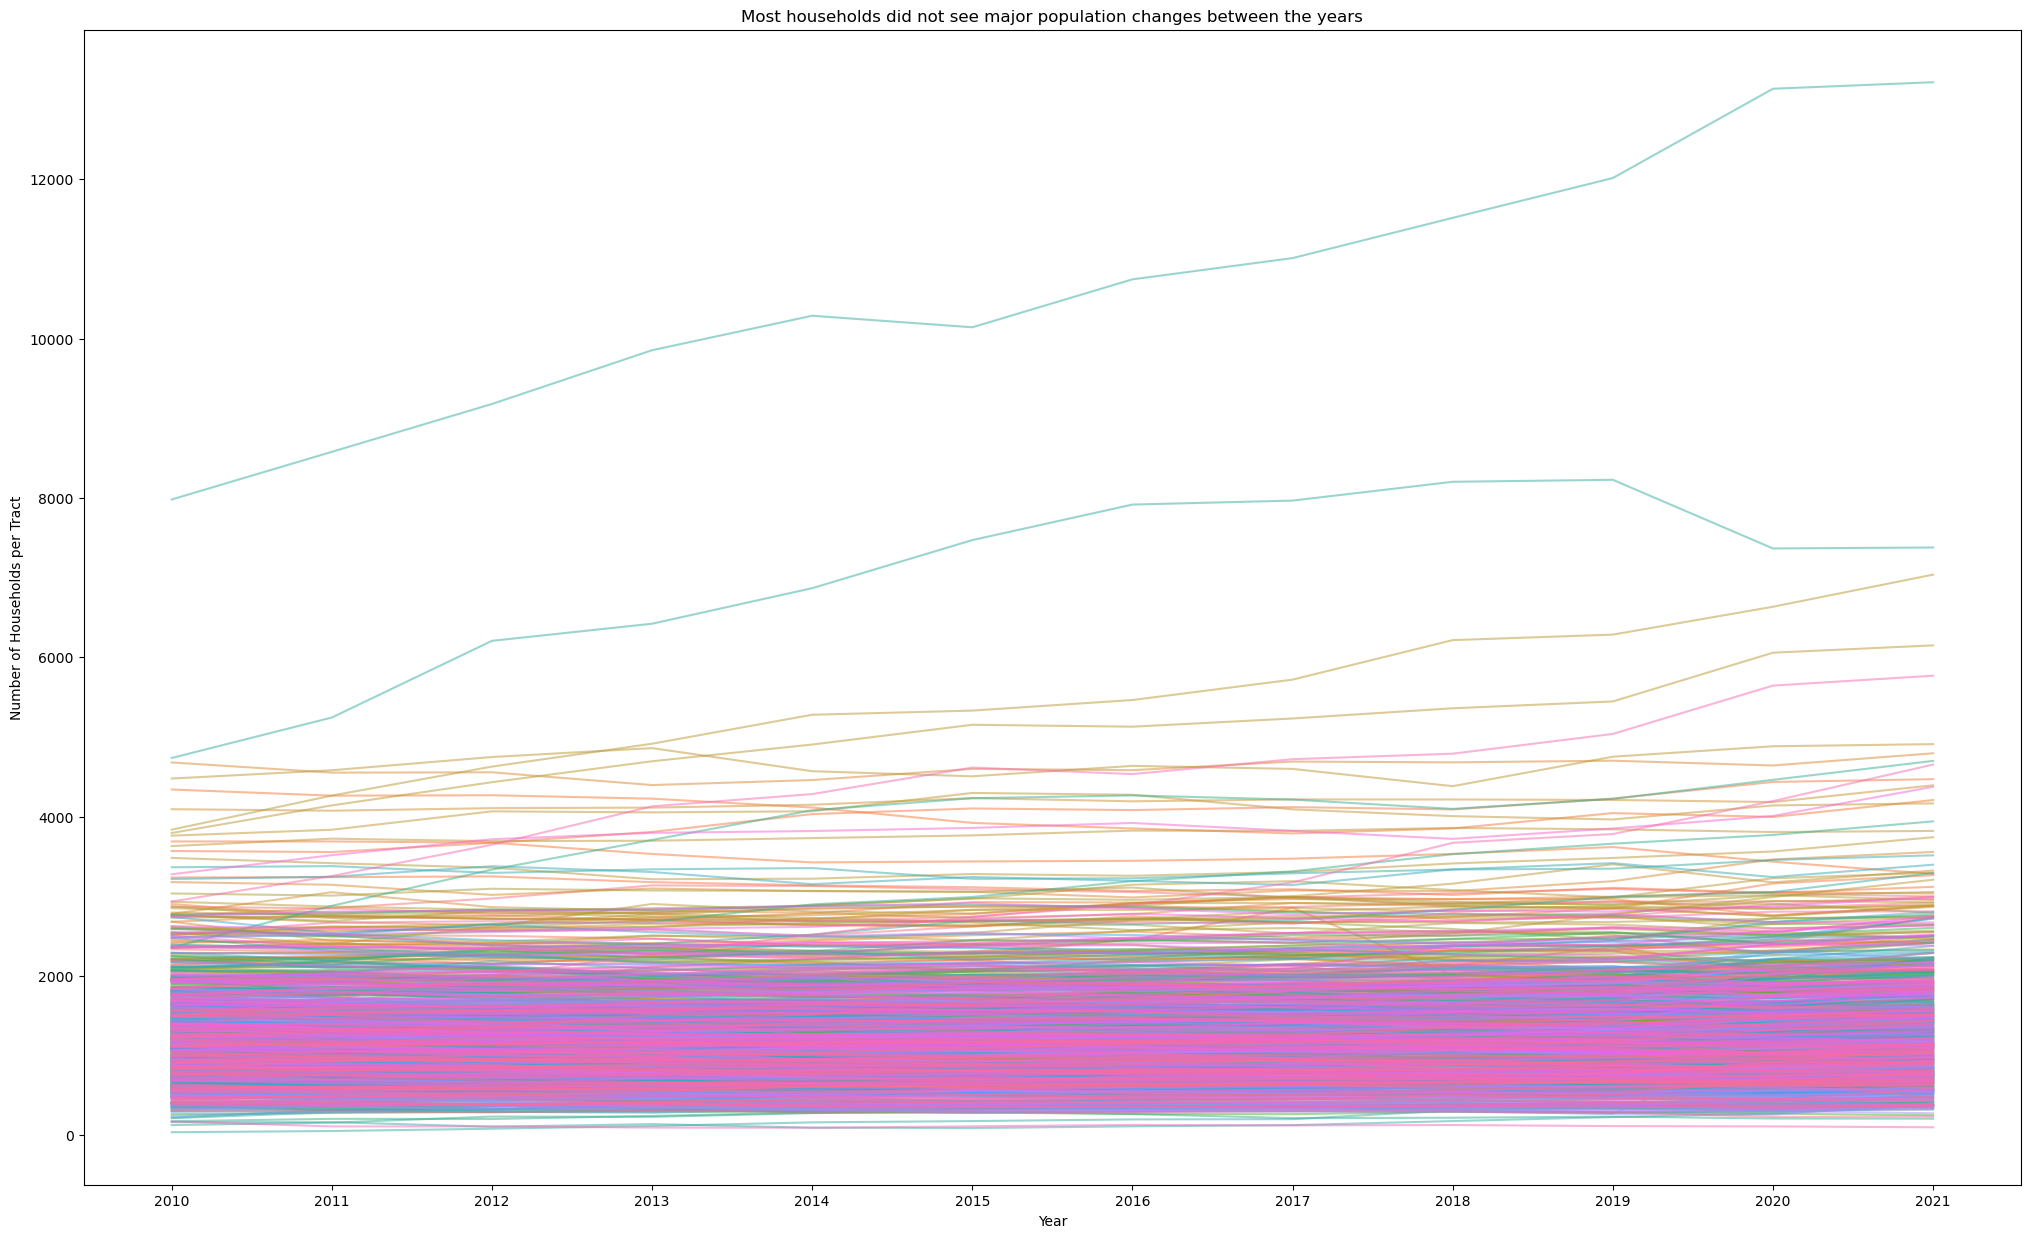

In [53]:
#plot the change for all census tracts
fig, ax = plt.subplots(figsize=(25,15))

sns.lineplot(data=household.T,dashes=False,legend=False,alpha=0.5,ax=ax)

li=[(i[-4::]) for i in household.columns]
ax.set_xticklabels(li)
ax.set_title('Most households did not see major population changes between the years')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Households per Tract')

plt.show();

* The line plot above shows that most census tracts did not experience major population changes between 2010 and 2021, as indicated by the relatively flat lines.
* There is one distinct outlier, which was confirmed to be one of the census tracts that was split into multiple tracts in 2019 but in order to be able to use its recoed before 2019, the 2 split tracts were merged back together for the purpose of this study

* Let's now conside the distribution of the household number averaged for all years per census tract

mean is 1339.41
median is 1194.5


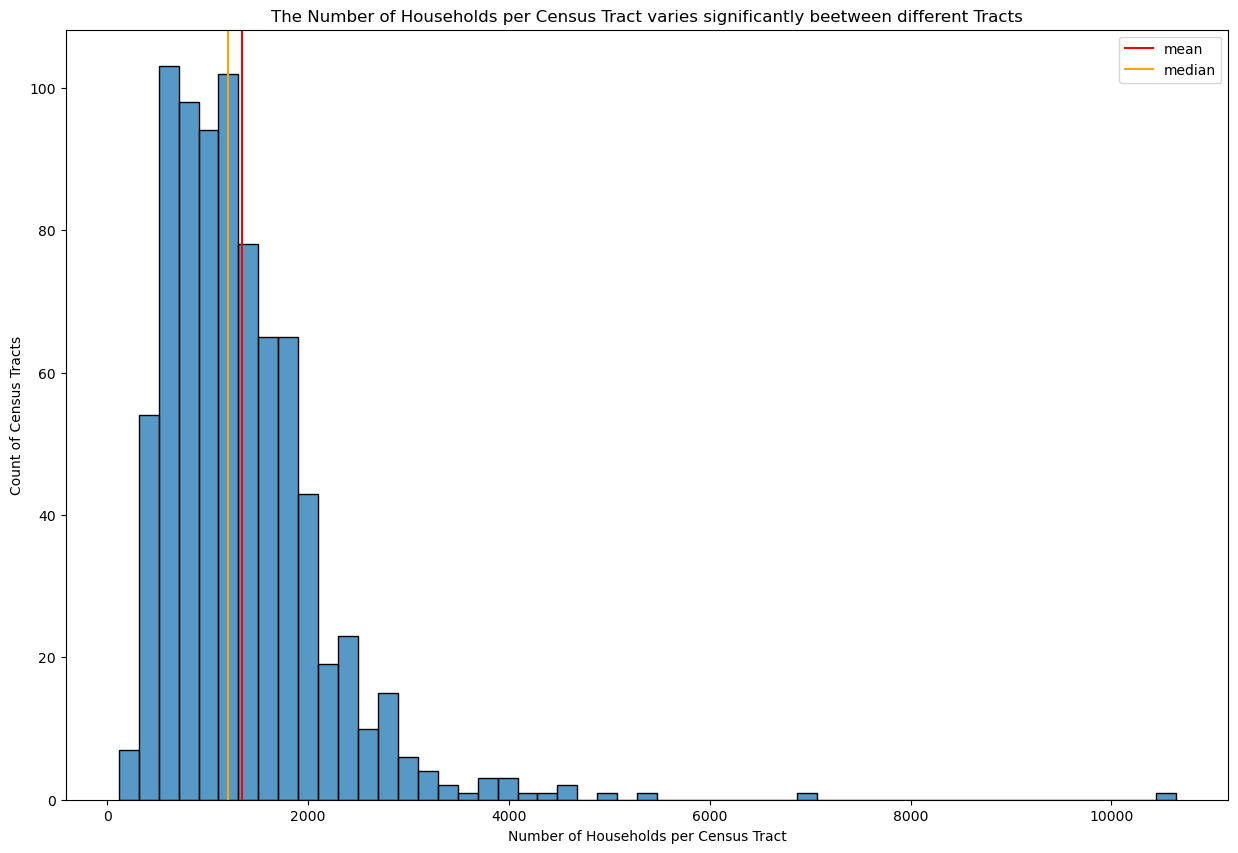

In [58]:
#Distribution of census tract sizes by the number of households
fig, ax = plt.subplots(figsize=(15,10))

sns.histplot(data=household.mean(axis=1))
plt.axvline(household.mean(axis=1).mean(),color='red',label='mean')
plt.axvline(household.mean(axis=1).median(),color='orange',label='median')

plt.title('The Number of Households per Census Tract varies significantly beetween different Tracts')
plt.xlabel('Number of Households per Census Tract')
plt.ylabel('Count of Census Tracts')

plt.legend()

print('mean is', round(household.mean(axis=1).mean(),2))
print('median is', round(household.median(axis=1).median(),2))

plt.show()


In [67]:
print(f'smallest census tract is {min(household.mean(axis=1)):.2f}')
print(f'largest census tract is {max(household.mean(axis=1)):.2f}')

smallest census tract is 115.08
largest census tract is 10639.58


* The distribution in the histogram above is wide, with the smallest tract having 115 households and the largest having 10639 household
* The distribution is slightly right-skewed, with the majority of the observations concentrated on the left side, and a few large values spread out on the right side
* Having a significant outlier might skew the data, but it would be difficult to accurately split the largest census tract into smaller ones because it is unknown which applications to allocate to which tract
* Smaller tracts can be merged easier to reduce the distribution width
* Additionally, very small tracts are likely to lead to volatility in the income data which would result in difficulties in making predictions

***
* It was established that there were no significant changes in the household numbers between census tracts, but the number of households between different tracts varied significantly
* Hence, extracting a useful feature from changes in the number of households would be challenging - instead, averaged household numbers could be used for all years
* The average number of households per tract will be calculated by combining the yearly measures into one column for each tract.


Calculate the average number of households per tract:

In [77]:
#create a new column called Household_Count that contains the median number of households per census tract, and adding it to the merged_wip2 DataFrame.

# Calculate median number of households per tract by first selecting only household columns using 'get_columns_with_regex' function
household_avg=get_columns_with_regex(merged_wip2,'Household').median(axis=1).rename('Household_Count').reset_index(drop=True)

#define a mask for non-household columns
mask_not_household=[col not in get_columns_with_regex(merged_wip2,'Household').columns for col in merged_wip2.columns]
#select only non-household columns
non_household=merged_wip2.iloc[:,mask_not_household].reset_index(drop=True)

#concat the two dataframes (houehold and non_household) together
merged_wip2=pd.concat([household_avg,non_household],axis=1)

Merge small census tract with their respective closest cencus tracts to remove any census tracts that have less than 600 residents

In [299]:
print(f"Currently there are {sum(merged_wip2['Household_Count']<600)} that have less than 600 households")

Currently there are 100 that have less than 600 households


In [79]:
#before merging census tract together, create a copy of the dataframe
merged_wip3=merged_wip2.copy()

In [81]:
# Define the threshold number of residents
n=600

# Select census tracts with less than n residents
small_tracts=merged_wip3[merged_wip3['Household_Count']<n]['Census_Tract']

# Initialize i
i=1

print('Current number of small tracts is',len(small_tracts))

# Loop until there are no more small tracts
while len(small_tracts)>0:
    #To keep track preint current number of small tracts
    print(len(small_tracts))

    #Find the closest census tract to each small tract
    closest_di={}
    for tract in small_tracts:
        #skip the tract if it had already been identified as the closest
        if tract in closest_di.values():
            continue
        #Generate a dictionary mapping each small tract to its closest neighboring tract
        closest_di[tract]=closest_tract_search(tract,ct_coord)
        #remined : ct_coord was a dataframe with the unique census tracts and their lat & lon coordinates

    # Merge each small tract with its closest neighboring tract
    merged_wip3=small_tracts_merge(merged_wip3,closest_di)

    #Create a dictionary which then can be used to remap census tract numbers and merge the small ones together
    if i==1:
    #on first iteration Initialize closest_di_result dictionary based on the previously defined closest_di
        closest_di_result=closest_di

    #after the first iteration keep addition to the dictionary
    else:
        closest_di_result.update(closest_di)
    i+=1

    small_tracts=merged_wip3[merged_wip3['Household_Count']<n]['Census_Tract']

Current number of small tracts is 100
100
6
2


* Update census tracts in the merged_wip3 dataframe using `closest_di_result` dictoinary

In [96]:
#update census tracts using a function *small_tracts_merge* defined in functions.py
#store the function output in a new dataframe named merged_wip4 
merged_wip4=small_tracts_merge(merged_wip3,closest_di_result)

#Note: small_tracts_merge updates census tracts and averages Income values, but sums Household_Count if two previously distinct tracts were merged into one

In [95]:
#Check the current size of the smallest census tract
min(merged_wip4['Household_Count'])

601.5

* In the updated dataframe, the smallest number of households is 601.5. Hence, the merge was conducted successfully

* Now dictionary `closest_di_result` can be used to change small census tract numbers to be merged with other census tracts
* After remapping and grouping census tracts together, there should be no tracts with less than 600 households

In [83]:
#recall the shape of ct_coord dataframe
ct_coord.sample()

,CENSUS_TRACT,LATITUDE,LONGITUDE
489,491000,41.699555,-87.627526


* Update `ct_coord` following the merge of small census tracts so that the geogrpahic information is up to date

In [236]:
#update ct_coord dataframe for future use
ct_coord['CENSUS_TRACT']=ct_coord['CENSUS_TRACT'].replace(closest_di_result)

#after applying closest_di_result dictionary, grouby census tract and average the remaining columns which are 'LATITUDE' and 'LONGITUDE' only 
ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

#check the updated shape
ct_coord.shape

(737, 3)

* Export `closest_di_result` dictionary

In [303]:
#export the dictionary used for census tract merging so that census tracts can be also renamed in the planning application notebook 
joblib.dump(closest_di_result, '../data/interim/wip/tract_merger.pkl')

['../data/interim/wip/tract_merger.pkl']

***
<center><h2>Income Mean & Median<center><h2>

* This section explores income data in the merged dataset from 2010 to 2021 for Chicago, with **the aim of establishing a method to evaluate if gentrification occurred based on the change in income.**</br> 
* Median and mean incomes will be compared to evaluate the most appropriate metric
* Recall the definition of gentrification : the process of rapid urban growth, which results in the displacement of lower-income residents by higher-income residents.

In [97]:
#copy dataframe
merged_clean=merged_wip4.copy()

* Let's preview the distribtions of Mean and Median Incomes for each census tract

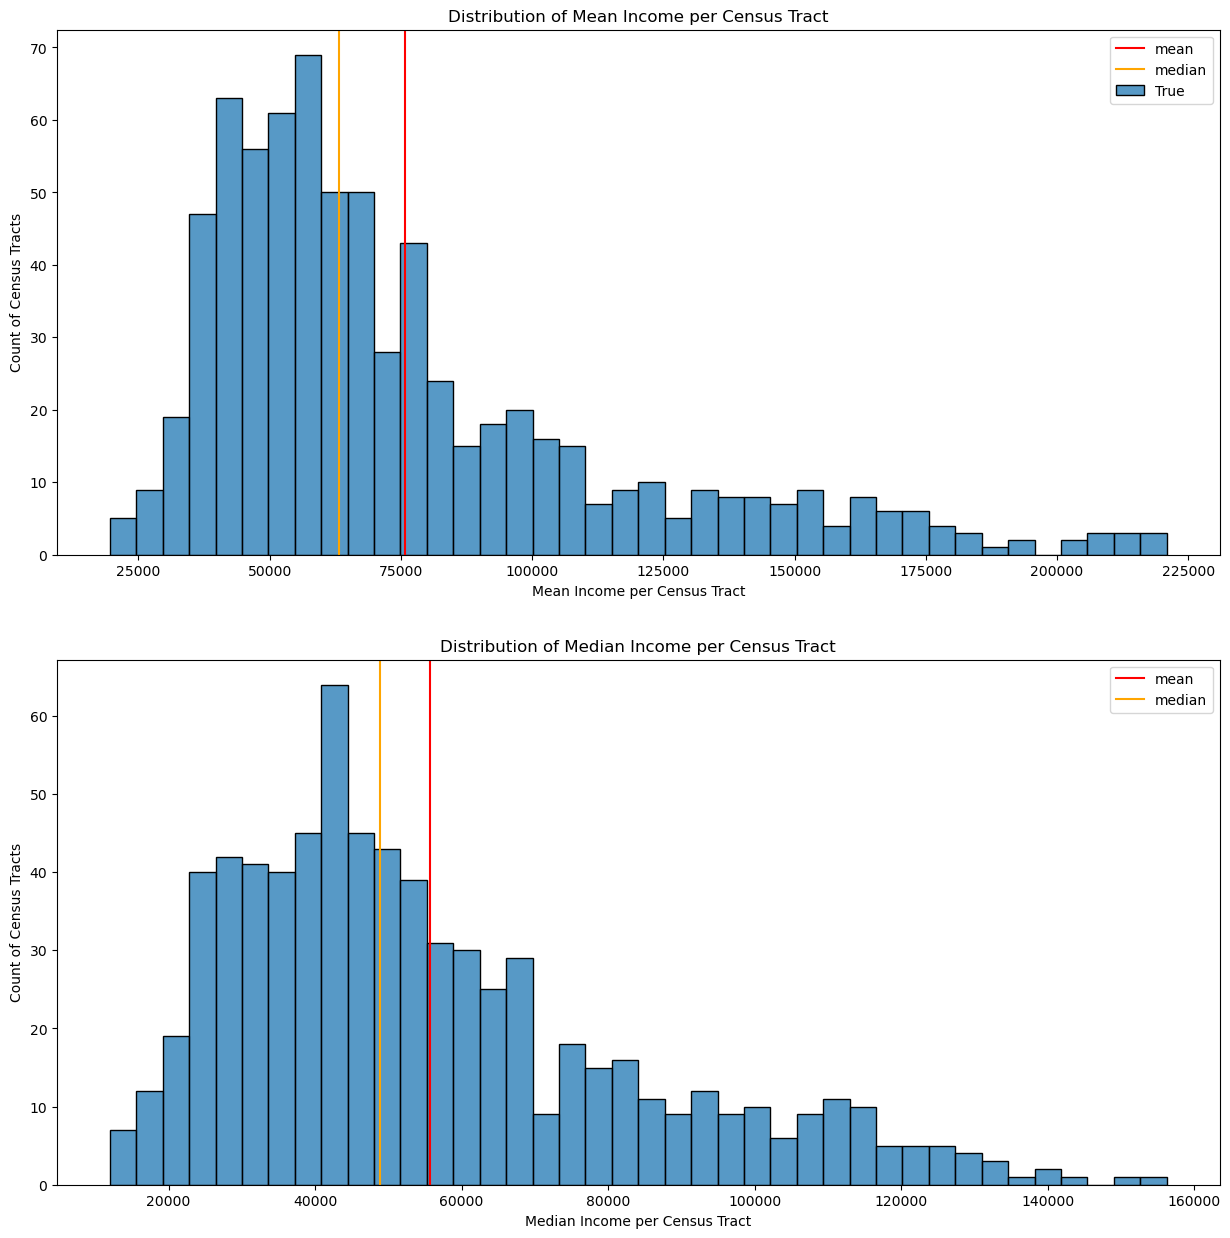

In [99]:
# Select the 'Mean' and 'Median' columns from the cleaned and merged dataset
inc_mean=get_columns_with_regex(merged_clean,'Mean')
inc_median=get_columns_with_regex(merged_clean,'Median')

fig, ax = plt.subplots(2,1,figsize=(15,15))

#Mean
plt.subplot(2,1,1)
sns.histplot(data=inc_mean.mean(axis=1),bins=40,label=True)
plt.axvline(inc_mean.mean(axis=1).mean(),color='red',label='mean')
plt.axvline(inc_mean.mean(axis=1).median(),color='orange',label='median')

plt.title('Distribution of Mean Income per Census Tract')
plt.xlabel('Mean Income per Census Tract')
plt.ylabel('Count of Census Tracts')
plt.legend()

plt.subplot(2,1,2)

#Median
sns.histplot(data=inc_median.mean(axis=1),bins=40)
plt.axvline(inc_median.mean(axis=1).mean(),color='red',label='mean')
plt.axvline(inc_median.mean(axis=1).median(),color='orange',label='median')

plt.title('Distribution of Median Income per Census Tract')
plt.xlabel('Median Income per Census Tract')
plt.ylabel('Count of Census Tracts')
plt.legend()

plt.show();

Graph Observations:
* From the histograms, we notice that both distributions have longer tails on the right side, meaning that there are more extreme values on the right side of the distribution
* Hence, there are more more high-income census tracts than low-income census tracts
* It should be noted that the distribution of mean incomes is higher than the distribution of median incomes - this likely due to the mean be more prone to be influecned by extreme outliers

**How can we measure change?**

Some of the intial ideas are
* Absolute change from 2010 to 2021 (with respect to the average)
  * but this is likely to only select geographies with high income
* Percentage change from 2010 to 2021 (with respect to the average)
  * on the other hand, this is likely to only select geographis with low income

* To understand how Income changed from 2010 to 2021 for the whole of Chicago, plot Median Income Change over the years

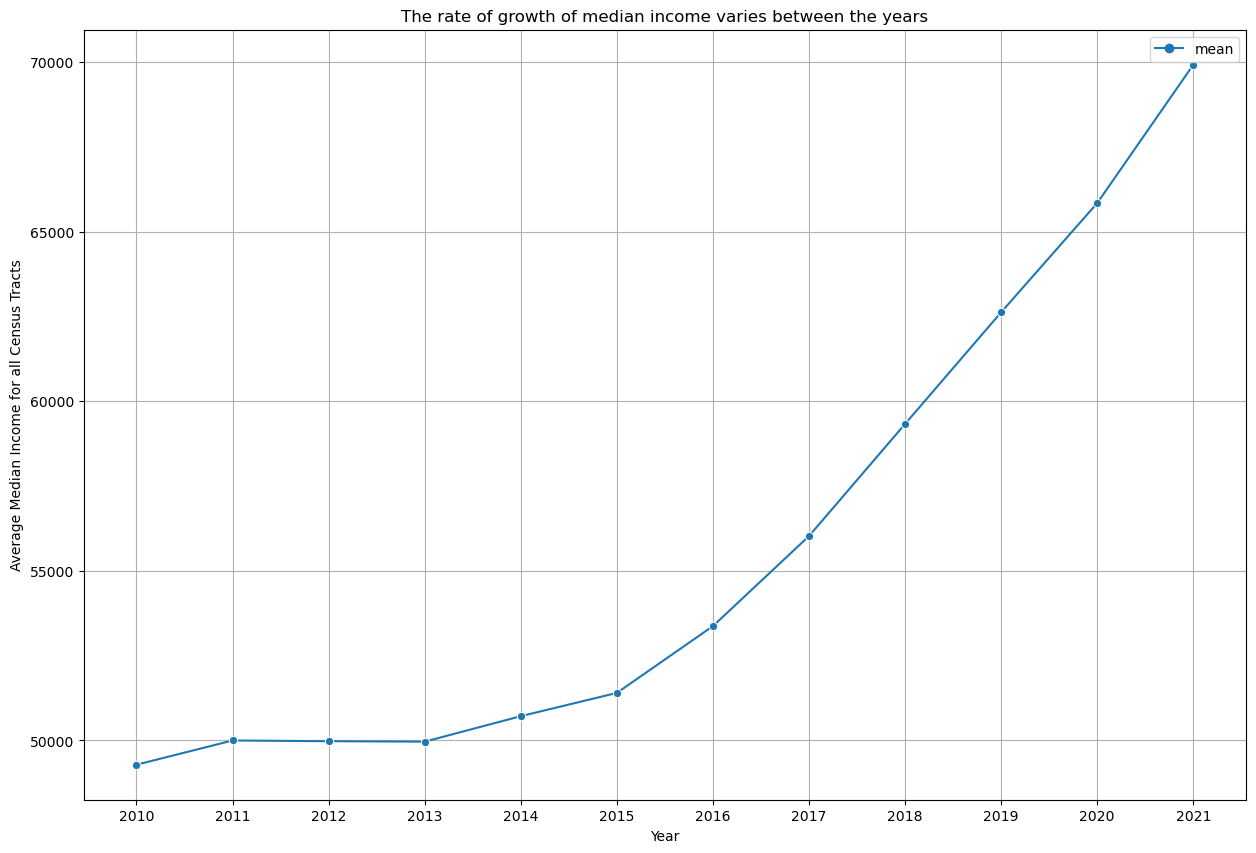

In [108]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=pd.DataFrame(inc_median.mean(axis=0).rename('mean')),markers=True)

plt.title('The rate of growth of median income varies between the years')
plt.xlabel('Year')
plt.ylabel('Average Median Income for all Census Tracts')

#set years as xticks
plt.xticks(range(0, len(inc_median.columns)), [str(year) for year in range(2010, 2022)])
plt.grid(True)
plt.show();

Graph Observations:
* The line plot demonstrates that between 2010 and 2021, the median income has been growing in Chicago
* However, it should be noted that the growth rate varied significantly between the years. 
* For example, there was minimal growth between 2011 and 2013, while the growth since 2016 has been very rapid
* Hence, any metric that we decide to use to evaluate gentrification has to be **with respect to the overall city change** to reflect any other external factors that can influence change in income for each tract
* Otherwise, the same absolute growth for one census tract could indicate gentrification between 2011 and 2013, but if considered from 2017 and 2019, it would be seen as slow

---
Let's define a function that will assist the exploration of different metrics that can be used to evaluate gentrification

In [270]:
def change_plot(df,year_start,year_end,mode='absolute',ranking='max',reg_ex='Mean'):
    '''
    Use:
        This function plots the change in income over a period between 2 years, and filters for census tracts that meet certain criteria.
    
    Inputs:
        df: dataframe containing income data
        year_start: start year for the income comparison
        year_end: end year for the income comparison
        mode: type of income change to evaluate ['absolute','percentage','combined'] (default: 'absolute')
        ranking: specifies whether to filter the top or bottom census tracts ['min',''max'] (default: 'max')
        reg_ex: regular expression to use for column selection ['Mean','Median'], (default: 'Mean')

    
    Output:
        A line plot showing the change in income for census tracts that meet the specified criteria, as well as the mean income over the years.
    '''
    #DATA PREPARATION

    df_copy=df.copy()
    #set Census_Tract as index so that census tracts appear in the legend box
    df_copy=df_copy.set_index('Census_Tract')

    #selecting mean or median columns using the custom function defined previously
    df_temp=get_columns_with_regex(df_copy,reg_ex)

    #convert year to column position
    start_pos=year_start-2010
    end_pos=year_end-2010

    #rename columns to only include years
    df_temp.columns=[(i[-4::]) for i in df_temp.columns]

    #compute the difference basen on the mode specified
    if mode =='absolute':
        df_diff=df_temp.iloc[:,end_pos]-df_temp.iloc[:,start_pos]
    elif mode =='percentage':
        df_diff=((df_temp.iloc[:,end_pos]-df_temp.iloc[:,start_pos])/df_temp.iloc[:,start_pos])
    #combined metric takes into account both absolute and percentage change in income, which helps to ensure that tracts of different income levels are considered
    elif mode=='combined':
        df_diff=np.log(abs(df_temp.iloc[:,end_pos]-df_temp.iloc[:,start_pos]))*((df_temp.iloc[:,end_pos]-df_temp.iloc[:,start_pos])/df_temp.iloc[:,start_pos])
        #log of absolute change is taken to reduce its impact due to absolute change being a greater number than percentage change

    #select if display top 10 maximum and minimal growth
    if ranking=='max':
        order_state=False
    elif ranking=='min':
        order_state=True

    #filter the tracts for which the specified type of growth occured and select TOP 10
    filtered_tracts=df_diff.sort_values(ascending=order_state).iloc[:10].index

    #Plot every 5th census tract in the dataset with low transparency
    sns.lineplot(data=df_temp.iloc[range(0,df_temp.shape[0],5)].T,dashes=False,alpha=0.1,legend=False)

    #Plot TOP 10 in full colours
    sns.lineplot(data=df_temp[df_temp.index.isin(filtered_tracts)].T,dashes=False,alpha=0.9)

    # Plot the mean income over the years
    sns.lineplot(data=pd.DataFrame(df_temp.mean(axis=0).T.rename('mean')),markers=True)
    #sns.lineplot(data=pd.DataFrame(df_temp.median(axis=0).T.rename('median')),markers=True)

    plt.xlabel('year')
    plt.ylabel('Income per census tract')



* Preview a sample plot using the function defined above

---
Start with plotting </br>
`Top 10 Census Tracts with the greatest mean absolute growth from 2010 to 2021`

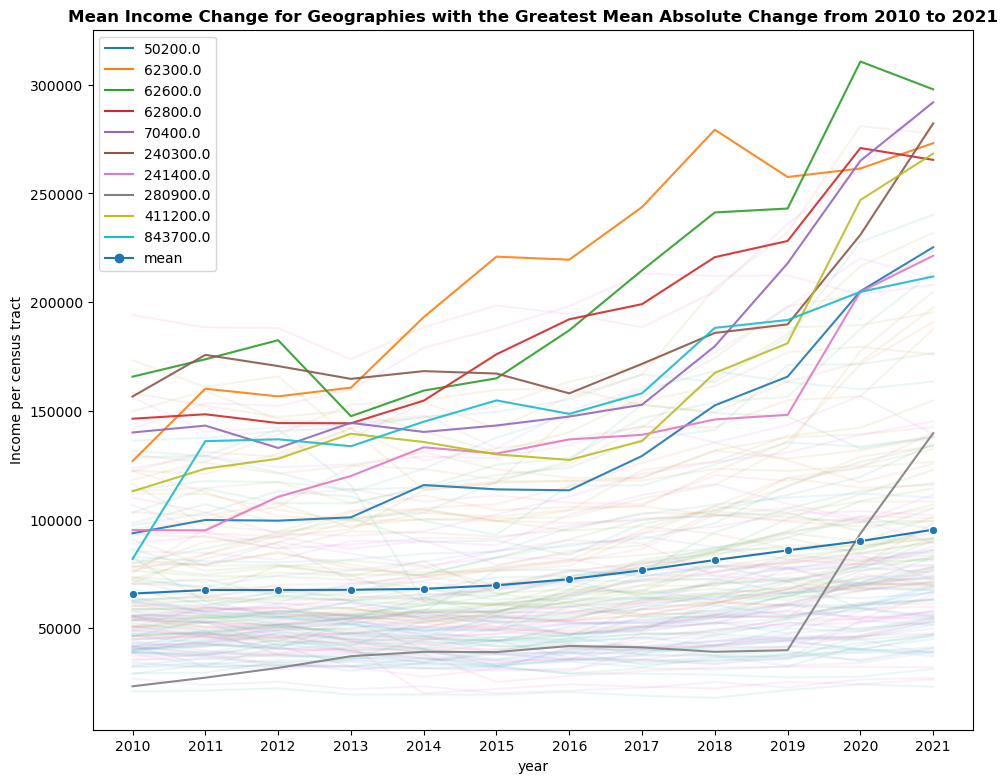

In [271]:
fig, ax = plt.subplots(1,1, figsize=(25,20))

plt.subplot(2,2,1)
change_plot(merged_clean,2010,2021,ranking='max',mode='absolute',reg_ex='Mean')
plt.title('Mean Income Change for Geographies with the Greatest Mean Absolute Change from 2010 to 2021',fontsize=12,fontweight='bold',wrap=True)

plt.show()

Graph Explanation and Observations
* The plot above displays (highlights) census tracts which saw the most significant absolute growth from 2010 to 2021
* Additionally, in the background, the plot displays randomly selected census tracts with low transparency to understand what portions of income levels are selected as top 10
* It is apparent that considering absolute growth results in the neighbourhoods with the highest income levels being selected
* The aim is to find a metric that would select census tracts from different income levels

---
Consider the same plot but for `Median`

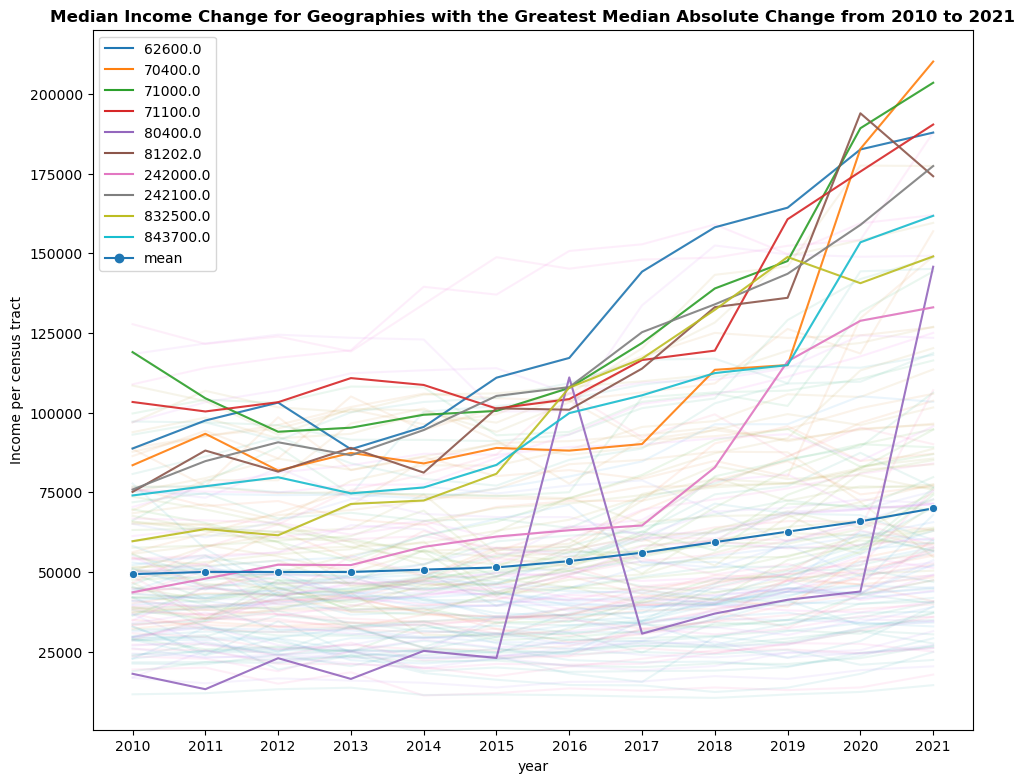

In [272]:
fig, ax = plt.subplots(1,1, figsize=(25,20))

plt.subplot(2,2,1)
change_plot(merged_clean,2010,2021,ranking='max',mode='absolute',reg_ex='Median')
plt.title('Median Income Change for Geographies with the Greatest Median Absolute Change from 2010 to 2021',fontsize=12,fontweight='bold',wrap=True)

plt.show()

Graph Observations and Further Conclusions
* Similarly to the mean, using the absolute change in the median income resulted in selecting only neighbourhoods with high-income levels. 
* This is not a desirable outcome since this project aims to consider all income levels</br>
  
**Volatility**
* Note that median income also demonstrates high volatility. In particular, for census tract number 80400 
* Straight away, one should note how this would result in a significant problem when trying to evaluate gentrification solely based on income:
  * Based on this metric, geography number 80400 was strongly gentrifying from 2015 to 2016 but was on a massive decline from 2016 to 2017
  * However, the planning application data for the 2 predictions would be very similar

**Model Options based on data available**
* Treating this as a classification problem would partially help with volatility since instead of treating it as a top decliner from 2016 to 2017 and skewing the model, this census tract would be just classified as not gentrified
* While classification would help with volatility, it might obscure the complexity of gentrification and lead to difficulties when deciding on the threshold
* Nevertheless, running a linear regression model on volatile data might result in wrong feature interpretation
  * As in the example with tract 80400, while its income is growing, trying to fit on data from 2016 to 2017 would result in features that cause growth and be interpreted as features that lead to decline.
  
`Overall, any improvement of the current study would need to include other metrics to evaluate gentrification accurately, such as education or employment rates.`</br>

* Check the household count for the census tract 80400 that is highly volatile to see if further grouping of small census tracts would help with volatility

In [273]:
merged_clean[merged_clean['Census_Tract']==80400]['Household_Count']

128    1947.5
Name: Household_Count, dtype: float64

* No, the highly volatile tract has a count of 1975 households which is above the median the given dataset. The volatility can be coming from outliers or changes to data collection or processing methods.

***
**External Research**</br>
Which Chicago Neighbourhoods have experiences gentrification. Let's look at two case studies, one located in downtown Chicago and other towards the suburbs
* Logan Square: This neighborhood, located on Chicago's northwest side - [source](https://interactive.wttw.com/chicago-by-l/neighborhoods/logan-square)
* Fulton Market District, located just outside of the central loop -[source](https://storymaps.arcgis.com/stories/c386af837bb4448e92fdaa748c03128d)
  
Both neighbourhoods have experienced gentrification recently. 

* Select census tract for both of these district and visualize them on the plot

C:\Users\44742\AppData\Local\Temp\ipykernel_235884\591827388.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



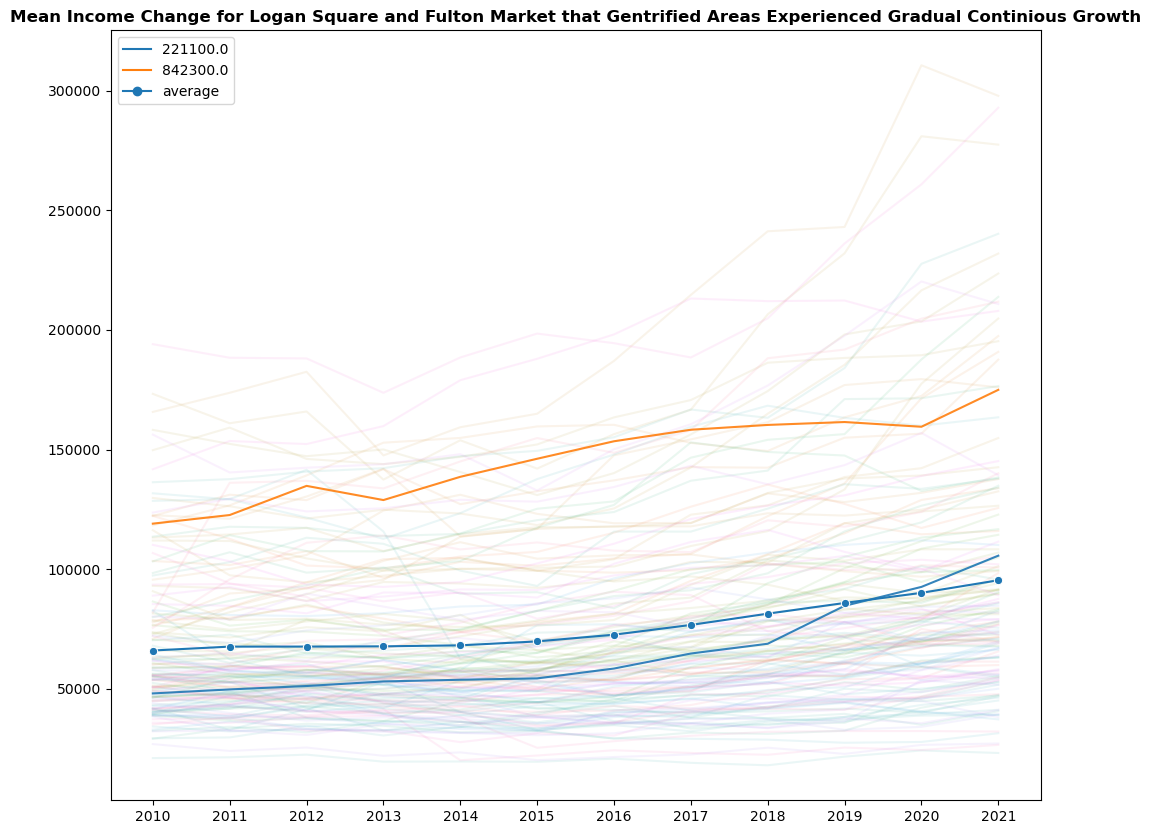

In [281]:
#Consider some of the Chicago Districts that are known to have been gentrified, such as 
df_temp=get_columns_with_regex(merged_clean.set_index('Census_Tract'),'Mean')

fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_temp.iloc[range(0,df_temp.shape[0],5)].T,dashes=False,alpha=0.1,legend=False)
sns.lineplot(data=df_temp[df_temp.index.isin([842300,221100])].T,dashes=False,alpha=0.9)
sns.lineplot(data=pd.DataFrame(df_temp.mean(axis=0).T.rename('average')),markers=True,dashes=True)

#select years from the column names by slicicng the last 4 characters
li=[(i[-4::]) for i in df_temp.columns]
ax.set_xticklabels(li)
plt.title('Mean Income Change for Logan Square and Fulton Market that Gentrified Areas Experienced Gradual Continious Growth',fontsize=12,fontweight='bold',wrap=True)
plt.show()

The line plot above compares the mean income changes of two areas undergoing gentrification: census tract '842300' in the Fulton Market District and an area around Logan Square ('221100'). </br>
* As seen in the plot, both areas have experienced a continuous and gradual increase in income over the years, consistent with the gentrification process./br>
* One can see that while Logan Square area had income below the average in 2010, in 2019 it crossed the average</br>
It is worth noting that gentrification is a long-term and often a process irreversible in the near future, and the plot highlights the persistent nature of the income changes in these areas.</br>
**Hence, our model should not be looking for spikes but instead evaluating long-term changes**

**How can census tracts of different income levels be selected?**

* Let's consider `percentage change` in income as a metric to evaluate gentrification
* The graph below will show Median Income Change for Geographies with the Greatest Median Percentage Change from 2010 to 2021

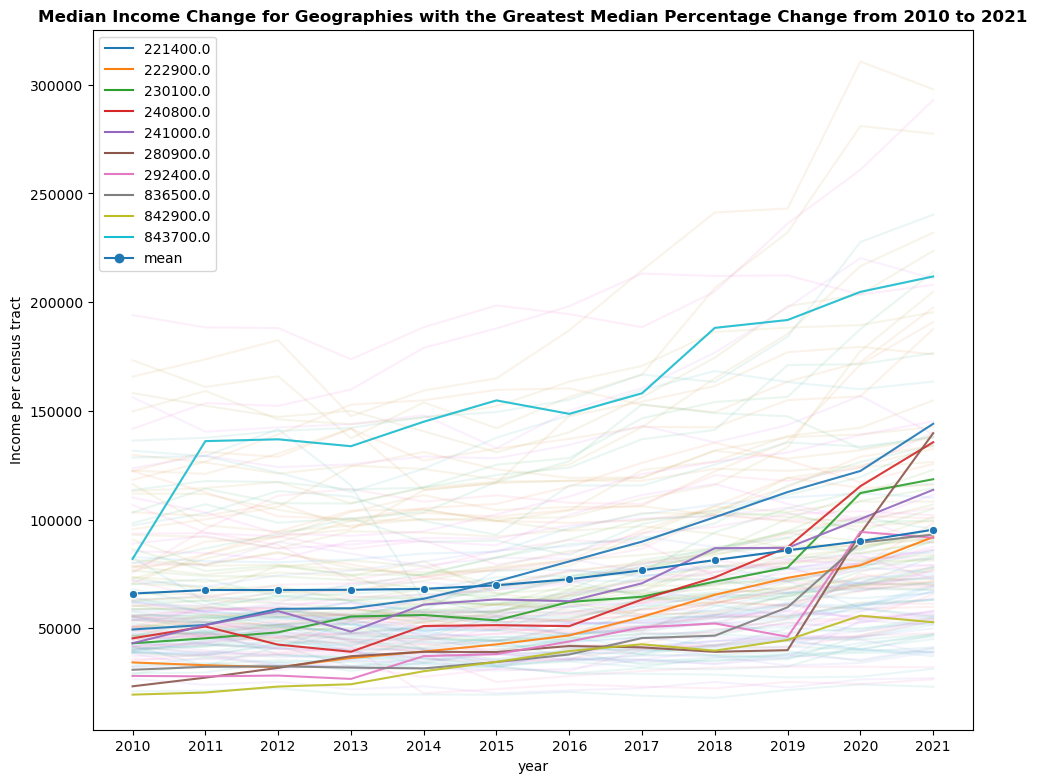

In [275]:
fig, ax = plt.subplots(1,1, figsize=(25,20))

plt.subplot(2,2,1)
#change mode to 'percentage'
change_plot(merged_clean,2010,2021,ranking='max',mode='percentage',reg_ex='Mean')
plt.title('Median Income Change for Geographies with the Greatest Median Percentage Change from 2010 to 2021',fontsize=12, fontweight='bold')

plt.show()

The percentage metric appears to perform better selecting census tracts with similar growth patters of Logan Square, with strating below the average in 2010 and then gradually crossong the average income levels by 2021</br>
Nevertheless, some areas such as 842900 appear to be selected incorrectly, as the tract remained well below the average city income levels by 2021</br>
It had high percentage growth as its starting mean income was one of the lowest in the city


* Now let's consider combined change metrics, which takes into account both absolute and percentage change in income, which should to ensure that tracts of different income levels are considered
  * In the scope of this project, combined change meteric can be defined as `log(absolute_change)/(percentage_change)`
  * log transformation is applied to absolute change as absolute change is a greater number than percentage_change. Therefore, the contribution of the absolute change should be reduced

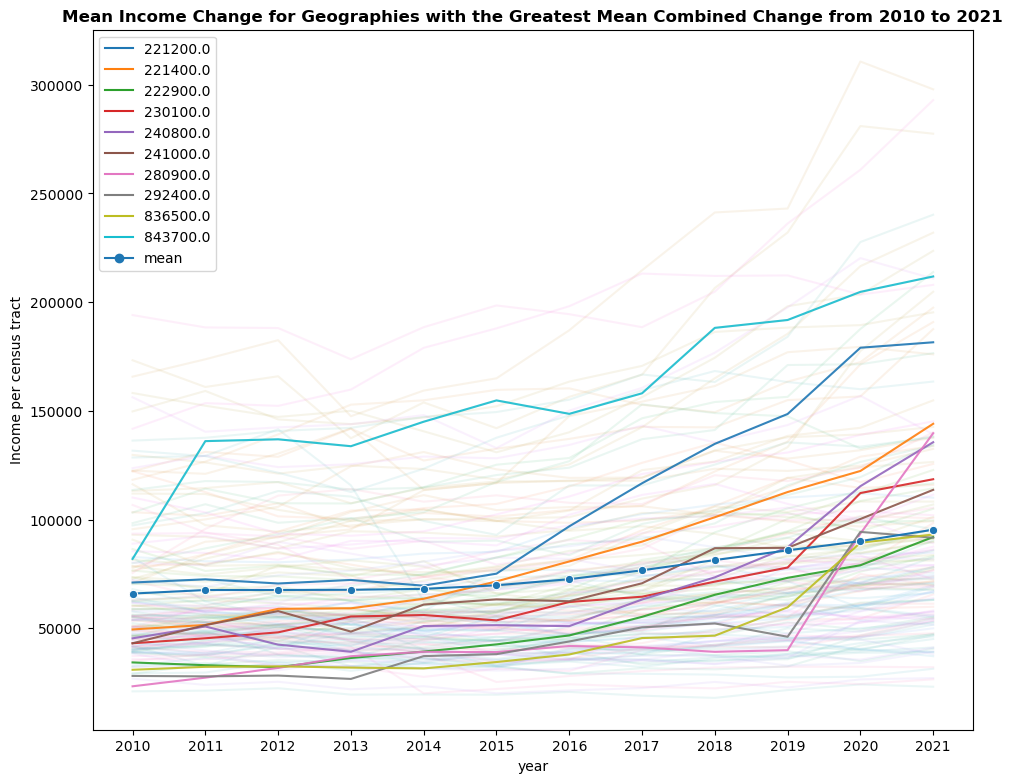

In [276]:
fig, ax = plt.subplots(1,1, figsize=(25,20))

plt.subplot(2,2,1)
change_plot(merged_clean,2010,2021,ranking='max',mode='combined',reg_ex='Mean')
plt.title('Mean Income Change for Geographies with the Greatest Mean Combined Change from 2010 to 2021',fontsize=12, fontweight='bold')

plt.show()

**Graph Description:** 
* The graph shows the mean income change for geographies with the greatest mean combined change from 2010 to 2021, where combined change is defined as `the logarithm of the absolute change multiplied by the percentage change.` </br>
  
**Graph Observations:** </br>
* Based on the graph, it can be observed that the combined metric produces more  accurate results than simply considering percentage or absolute changed.
* Overall, the combined metric is similar to the percentage metric but selects a few more higher income areas
* Most selected areas were below the city income average in 2010, but crossed the boundary by 2021, indicating a demographic change from low income to higher income.
* While it is possible that people in the areas simply started earning more. 
* Given that the growth is above the city average, for the scope of this project, it will be assumed that more people with high income had to move into the area for this change to be observed.

`The combined change metric is calculated as:`

$log(|Income_{t2} - Income_{t1}|) * \frac{(Income_{t2} - Income_{t1})}{Income_{t1}}$

where:

* $Income_{t1}$: The income in the initial year (t1)
* $Income_{t2}$: The income in the final year (t2)
* $|Income_{t2} - Income_{t1}|$: The absolute change in income from t1 to t2
* $ \frac{(Income_{t2} - Income_{t1})}{Income_{t1}}$: The percentage change in income from t1 to t2
</br></br>
This formula calculates the combined change metric for any two generic years by taking the logarithm of the absolute change in income multiplied by the percentage change in income between two years.


In [296]:
#let's define this as a separate function that computes the combined metric given two 

def comb_change_calc(start,finish):
    '''
    Use
        Calculates the combined change metric between incomes from two years using the formula: 
        log(abs(finish-start))/((finish-start)/start)
    
    Inputs:
        start (float or int): The initial value (income for the start year - year the prediction is made FROM)
        finish (float or int): The final value (income for the final year - year the prediction is made FOR)
    
    Returns:
        x (float): The combined change metric for two incomes.
    '''
    x=np.log(abs(finish-start))/((finish-start)/start)

    return x


In [298]:
#now let's define a function that selects the correct columns from the whole dataframe and applies combined change calculatation for specific years

def comb_change(df,year_start,n):

    '''
    Use:
        Calculate the combined change of income metric for specific years.
    Inputs:
        df (DataFrame): DataFrame containing Mean_Income data.
        year_start (int): Current year (the year we are making the prediction from).
        n (int): The number of years ahead we are making the prediction for.
    Returns:
        A list of combined change metric of income values.
    '''

    #select income values from df for year_start (current year) by selecting the Mean_Income column for the given year
    str_current='Mean_Income_'+str(year_start)
    income_val_current=list(df[str_current])

    #year_final for which we are making the prediction (future year)

    #find the final year
    year_final=year_start+n

    #select the column containing Mean Income for the final year
    str_final='Mean_Income_'+str(year_final)
    income_val_final=list(df[str_final])

    comb_change_li=[]
    for (a,b) in zip(income_val_current,income_val_final):
        comb_change_li.append(comb_change_calc(a,b))

    return comb_change_li

In [ ]:
sns.histplot(data=comb_change(merged_clean,2010,11))

[27.04575030236296,
 50.22806154907267,
 40.772216984333824,
 37.89899554940251,
 16250.295654760921,
 17.61571379986109,
 44.49053034903065,
 43.134835955747896,
 23.519630972198776,
 18.507538796423244,
 81.75134582902913,
 43.59453603669212,
 18.038452633719228,
 48.405984512015685,
 14.731130127434351,
 15.808000173315506,
 76.62146240778799,
 19.93612544909134,
 16.71544909656517,
 18.504052043377687,
 26.32323263869764,
 48.01672533134029,
 20.768846862975458,
 53.493884065005886,
 -4240.975059924807,
 111.94071028054252,
 35.533236681921416,
 7.86628385026168,
 16.033633001324382,
 19.398534774411278,
 10.680214885894754,
 14.361923150870801,
 19.14228037842272,
 30.400851960076267,
 13.573312249804461,
 18.48534655680762,
 19.454228741297136,
 31.004806658716248,
 18.42688073383918,
 14.609171139352497,
 296.9915258582155,
 17.309577512250126,
 14.603399823577393,
 68.19891538872292,
 27.66289264157698,
 23.926079349877686,
 36.30947969589618,
 29.07851567704161,
 33.1077518794

* So far, we have considered evaluating different metrics by selecting top 10 tracts when evaluated using each metric.
* Let's now visualise this data on the map to ensure that the chosen metric does not result in a geographic bais when defining gentrification
* For example, this would have happened with absolute metric and mostly central districts only would be classified as gentrified

In [282]:
#Define a function to add census tract latitude and longitude coordinates back

def coord(df, df_coord):
    """
    Use:
        This merges input the first dataframe, df, with the second, df_coord, adding coordinates for each Census Tract. 
    
    Inputs:
        df (pandas.DataFrame): The DataFrame containing Census Tract information to be merged with coordinates.
        df_coord (pandas.DataFrame): The DataFrame containing the coordinates for each Census Tract.
    
    Returns:
        df_result (pandas.DataFrame): A new DataFrame with Census Tract information and corresponding coordinates. 
    """
    df_result=df.copy()
    df_result=df.merge(df_coord, how='left', left_on='Census_Tract', right_on='CENSUS_TRACT')
    return df_result

In [210]:
#df_export_prep=merged_clean.copy()

In [241]:
import plotly.express as px

change=np.log(merged_clean['Mean_Income_2021']-merged_clean['Mean_Income_2010'])*(df_export_prep['Median_Income_2021']/df_export_prep['Median_Income_2010'])

fig = px.scatter_mapbox(coord(df_export_prep), lat="LATITUDE", lon="LONGITUDE", color=change, size="Household_Count", size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

c:\Users\44742\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log



***
<center><h3>Dataset Export<center><h3>

The purpose of this subsection is:
* [ ] Conduct final cleaning of the dataframe
* [ ] Remove unnecessary columns
* [ ] Combine columns to form target columns
    * *at this stage might be multiple target columns to test different models*


***
**Remove unnecessary columns**
* Based on the explorations done above, median was chosen over mean. Let's drop columns containing mean

In [317]:
df_export_prep=merged_clean.iloc[:,[not bool(re.search('Mean',col)) for col in merged_clean]].copy()
df_export_prep

,Census_Tract,Median_Income_2010,Median_Income_2011,Median_Income_2012,Median_Income_2013,Median_Income_2014,Median_Income_2015,Median_Income_2016,Median_Income_2017,Median_Income_2018,Median_Income_2019,Median_Income_2020,Median_Income_2021,Household_Count
0,10100,36905.0,31919.0,31063.0,32191.0,30798.0,32188.0,29861.0,33750.0,37985.0,32474.0,42891.0,60316.0,2224.5
1,10201,40681.0,41528.0,38766.0,39908.0,40532.0,39122.0,38861.0,40841.0,39549.0,45639.0,39955.0,43750.0,2644.5
2,10202,35724.0,44107.0,36369.0,36315.0,25250.0,27318.0,29432.0,36563.0,38370.0,41486.0,43839.0,45096.0,1109.5
3,10300,45224.0,45964.0,41315.0,43483.0,42606.0,37111.0,37515.0,36870.0,38866.0,41250.0,44375.0,60846.0,2830.0
4,10400,44018.0,48138.0,43125.0,41765.0,38531.0,38384.0,37228.0,39634.0,39152.0,39700.0,37198.0,43024.0,1940.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,73986.0,76875.0,79688.0,74643.0,76488.0,83571.0,99821.0,105408.0,112386.0,114886.0,153424.0,161739.0,964.5
721,843800,38143.0,41172.0,35238.0,32260.0,33229.0,38333.0,38060.0,45833.0,34375.0,36042.0,40966.0,29844.0,612.5
722,843900,35663.0,31774.0,29094.0,24153.0,27303.0,26975.0,27012.0,32750.0,34381.0,33028.0,50496.0,57682.0,1890.0
723,844600,33571.0,29052.0,36979.0,15987.5,15122.5,16018.5,26000.0,35833.0,43567.5,46565.0,48955.0,67634.0,601.5


****

In [318]:
preview(df_export_prep)

The dataframe shape is (725, 14)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int32,0,0.000000,10100.0,844700.0,150402.0
Median_Income_2010,float64,0,0.000000,36905.0,31204.5,46563.0
Median_Income_2011,float64,0,0.000000,31919.0,28496.0,53837.0
Median_Income_2012,float64,0,0.000000,31063.0,21358.0,58125.0
Median_Income_2013,float64,0,0.000000,32191.0,27439.5,56969.0
Median_Income_2014,float64,0,0.000000,30798.0,22994.0,56273.0
Median_Income_2015,float64,0,0.000000,32188.0,22792.5,57339.0
Median_Income_2016,float64,1,0.137931,29861.0,24070.0,59000.0
Median_Income_2017,float64,0,0.000000,33750.0,25552.5,64545.0


In [ ]:
preview(df_export_prep)

The dataframe shape is (725, 14)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int32,0,0.0,10100.0,844700.0,730700.0
Median_Income_2010,float64,0,0.0,36905.0,31204.5,43571.0
Median_Income_2011,float64,0,0.0,31919.0,28496.0,40558.0
Median_Income_2012,float64,0,0.0,31063.0,21358.0,42042.0
Median_Income_2013,float64,0,0.0,32191.0,27439.5,41739.0
Median_Income_2014,float64,0,0.0,30798.0,22994.0,42628.0
Median_Income_2015,float64,0,0.0,32188.0,22792.5,43309.0
Median_Income_2016,float64,0,0.0,29861.0,24070.0,47656.0
Median_Income_2017,float64,0,0.0,33750.0,25552.5,49688.0


In [ ]:
coord(df_export_prep)

,Census_Tract,Median_Income_2010,Median_Income_2011,Median_Income_2012,Median_Income_2013,Median_Income_2014,Median_Income_2015,Median_Income_2016,Median_Income_2017,Median_Income_2018,Median_Income_2019,Median_Income_2020,Median_Income_2021,Household_Count,CENSUS_TRACT,LATITUDE,LONGITUDE
0,10100,36905.0,31919.0,31063.0,32191.0,30798.0,32188.0,29861.0,33750.0,37985.0,32474.0,42891.0,60316.0,2224.5,10100,42.021004,-87.669351
1,10201,40681.0,41528.0,38766.0,39908.0,40532.0,39122.0,38861.0,40841.0,39549.0,45639.0,39955.0,43750.0,2644.5,10201,42.016344,-87.679624
2,10202,35724.0,44107.0,36369.0,36315.0,25250.0,27318.0,29432.0,36563.0,38370.0,41486.0,43839.0,45096.0,1109.5,10202,42.016615,-87.673653
3,10300,45224.0,45964.0,41315.0,43483.0,42606.0,37111.0,37515.0,36870.0,38866.0,41250.0,44375.0,60846.0,2830.0,10300,42.016164,-87.666474
4,10400,44018.0,48138.0,43125.0,41765.0,38531.0,38384.0,37228.0,39634.0,39152.0,39700.0,37198.0,43024.0,1940.5,10400,42.001935,-87.659335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,73986.0,76875.0,79688.0,74643.0,76488.0,83571.0,99821.0,105408.0,112386.0,114886.0,153424.0,161739.0,964.5,843700,41.944478,-87.689248
721,843800,38143.0,41172.0,35238.0,32260.0,33229.0,38333.0,38060.0,45833.0,34375.0,36042.0,40966.0,29844.0,612.5,843800,41.802669,-87.643416
722,843900,35663.0,31774.0,29094.0,24153.0,27303.0,26975.0,27012.0,32750.0,34381.0,33028.0,50496.0,57682.0,1890.0,843900,41.774995,-87.581733
723,844600,33571.0,29052.0,36979.0,15987.5,15122.5,16018.5,26000.0,35833.0,43567.5,46565.0,48955.0,67634.0,601.5,844600,41.813495,-87.624274


In [ ]:
df_export_prep.to_csv('../data/interim/income_all_years.csv')

****

***
* **Outliers?**

In [ ]:
closest_tract_search(70400,income_coord)

70500

In [ ]:
merged_clean[merged_clean['Census_Tract'].isin([70400,70500])]

,Census_Tract,Mean_Income_2010,Median_Income_2010,Mean_Income_2011,Median_Income_2011,Mean_Income_2012,Median_Income_2012,Mean_Income_2013,Median_Income_2013,Mean_Income_2014,...,Median_Income_2017,Mean_Income_2018,Median_Income_2018,Mean_Income_2019,Median_Income_2019,Mean_Income_2020,Median_Income_2020,Mean_Income_2021,Median_Income_2021,Household_Count
111,70400,140078.0,83468.0,143221.0,93347.0,132941.0,81800.0,144494.0,87333.0,140315.0,...,90125.0,179715.0,113409.0,217871.0,114902.0,265026.0,182750.0,291866.0,210147.0,1593.5
112,70500,159607.0,99115.0,167998.0,101406.0,199250.0,108958.0,197557.0,104803.0,191302.0,...,120885.0,261051.0,155729.0,265576.0,152850.0,224568.0,136016.0,234527.0,144389.0,1292.5


In [ ]:
merged_clean

,Census_Tract,Mean_Income_2010,Median_Income_2010,Mean_Income_2011,Median_Income_2011,Mean_Income_2012,Median_Income_2012,Mean_Income_2013,Median_Income_2013,Mean_Income_2014,...,Median_Income_2017,Mean_Income_2018,Median_Income_2018,Mean_Income_2019,Median_Income_2019,Mean_Income_2020,Median_Income_2020,Mean_Income_2021,Median_Income_2021,Household_Count
0,10100,51153.0,36905.0,46073.0,31919.0,45816.0,31063.0,47297.0,32191.0,44918.0,...,33750.0,56105.0,37985.0,55297.0,32474.0,75017.0,42891.0,69746.0,60316.0,2224.5
1,10201,52591.0,40681.0,54747.0,41528.0,52577.0,38766.0,53528.0,39908.0,61415.0,...,40841.0,61626.0,39549.0,53752.0,45639.0,56526.0,39955.0,62192.0,43750.0,2644.5
2,10202,47699.0,35724.0,50757.0,44107.0,51070.0,36369.0,47536.0,36315.0,43047.0,...,36563.0,49615.0,38370.0,51055.0,41486.0,57610.0,43839.0,58572.0,45096.0,1109.5
3,10300,57075.0,45224.0,57791.0,45964.0,54026.0,41315.0,53037.0,43483.0,61496.0,...,36870.0,69967.0,38866.0,64068.0,41250.0,66120.0,44375.0,71497.0,60846.0,2830.0
4,10400,58457.0,44018.0,60445.0,48138.0,60477.0,43125.0,63217.0,41765.0,59091.0,...,39634.0,54235.0,39152.0,54680.0,39700.0,53636.0,37198.0,58464.0,43024.0,1940.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,81933.0,73986.0,136092.0,76875.0,136926.0,79688.0,133753.0,74643.0,145015.0,...,105408.0,188171.0,112386.0,191791.0,114886.0,204726.0,153424.0,211809.0,161739.0,964.5
721,843800,51766.0,38143.0,50963.0,41172.0,42772.0,35238.0,39192.0,32260.0,41212.0,...,45833.0,44610.0,34375.0,46264.0,36042.0,71232.0,40966.0,48387.0,29844.0,612.5
722,843900,48229.0,35663.0,45613.0,31774.0,52815.0,29094.0,44805.0,24153.0,46341.0,...,32750.0,48169.0,34381.0,49417.0,33028.0,56631.0,50496.0,59008.0,57682.0,1890.0
723,844600,44142.0,33571.0,44861.0,29052.0,47701.0,36979.0,23881.5,15987.5,23596.5,...,35833.0,44126.0,43567.5,54296.5,46565.0,62895.0,48955.0,69381.0,67634.0,601.5


In [ ]:
thresholds = {}

threshold = np.percentile(df_export_prep['5y_inc_change_2015'], 99)
thresholds['5y_inc_change_2015']=round(threshold,2)

threshold = np.percentile(df_export_prep['5y_inc_change_2021'], 99)
thresholds['5y_inc_change_2021']=round(threshold,2)


In [ ]:
df_export_prep

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021
0,10100,2224.5,-3588.26,124255.31
1,10201,2644.5,-1441.80,6196.53
2,10202,1109.5,-4915.49,36773.86
3,10300,2830.0,-5463.22,61374.44
4,10400,1940.5,-4284.07,7741.24
...,...,...,...,...
720,843700,964.5,12229.37,162555.85
721,843800,612.5,191.90,-5051.69
722,843900,1890.0,-4970.58,139855.94
723,844600,601.5,-3996.26,281729.02


In [ ]:
def threshold_adjust(df, di):
    df_result=df.copy()
    for col,threshold in di.items():
        df_result[col]=[i if i<threshold else threshold for i in df_result[col]]
    return df_result


In [ ]:
df_scaled=threshold_adjust(df_export_prep,thresholds)

In [ ]:
fig = px.scatter_mapbox(coord(df_scaled), lat="LATITUDE", lon="LONGITUDE", color="5y_inc_change_2021", size="Household_Count", size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

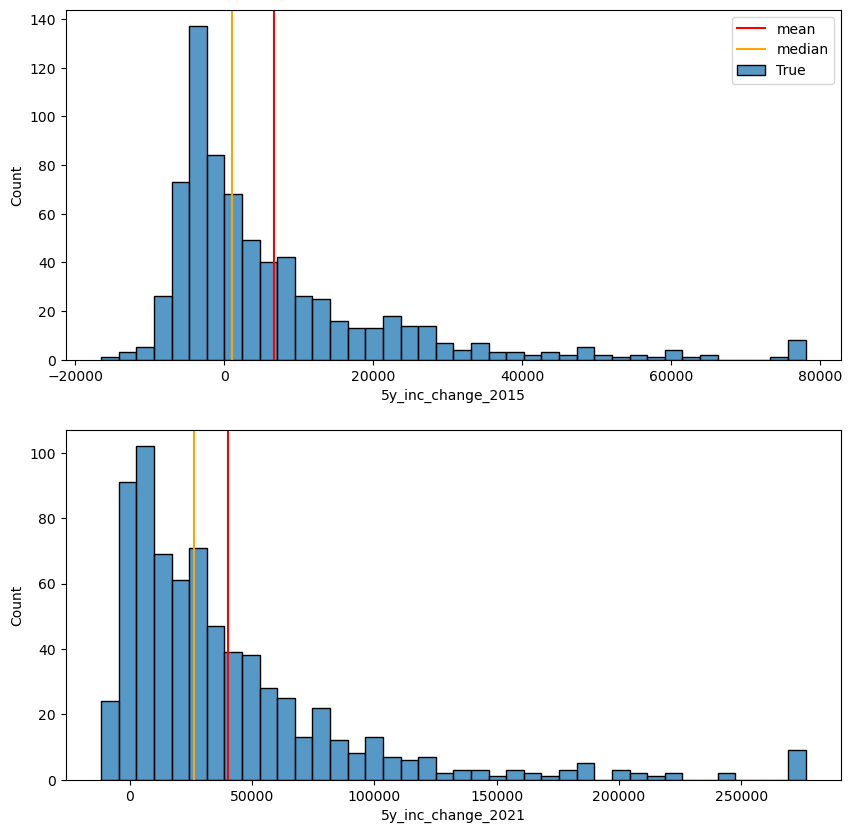

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

plt.subplot(2,1,1)
sns.histplot(data=df_scaled['5y_inc_change_2015'],bins=40,label=True)
plt.axvline(df_scaled['5y_inc_change_2015'].mean(),color='red',label='mean')
plt.axvline(df_scaled['5y_inc_change_2015'].median(),color='orange',label='median')

#plt.title('Distribution of Mean Income per Census Tract')
#plt.xlabel('Mean Income per Census Tract')
#plt.ylabel('Count of Census Tracts')
plt.legend()

plt.subplot(2,1,2)

sns.histplot(data=df_scaled['5y_inc_change_2021'],bins=40)
plt.axvline(df_scaled['5y_inc_change_2021'].mean(),color='red',label='mean')
plt.axvline(df_scaled['5y_inc_change_2021'].median(),color='orange',label='median')

#plt.title('Distribution of Median Income per Census Tract')
#plt.xlabel('Median Income per Census Tract')
#plt.ylabel('Count of Census Tracts')


plt.show();

***
<center><h3>Relative Growth<center><h3>

In [ ]:
df_target=df_scaled.copy()

* **Change Evaluation**
* Since more than 1 time period is being considered, the change should be considered with respect to the overall change

***
**Create Sample Target Columns**
* *Target 1*: 
    * **Percentage Variation from the Median of the Cook County (`Based on Combined Difference from 2010 to 2021`)**
        * `Logistic Classification
            * Baseline Classification: [0,1] based on less/grater than 1
            * [0,1,2] Classification
            
* *Target 2*:
    * **Absolute Variation from the Median of the Cook County (`Based on the Absolute Difference from 2010 to 2021`)**
        * `Linear Regression`
* *Target 3*:
    * **Repeat 1,2 for 5 year periods**

In [ ]:
df_target.sample()

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021
652,833000,1758.5,46815.29,188520.05


In [ ]:
df_target.mean()

Census_Tract          397765.005517
Household_Count         1478.379310
5y_inc_change_2015      6621.020028
5y_inc_change_2021     40321.301338
dtype: float64

In [ ]:
target_di={}

**1) More or less than the mean for simple 50/50 classification**

In [ ]:
list(df_target.columns)

['Census_Tract', 'Household_Count', '5y_inc_change_2015', '5y_inc_change_2021']

In [ ]:
def col_names(df,reg):
    ''''Outputs column names that contain a specified string as a lsit'''
    return [col for col in df.columns if bool(re.search(reg,col))]

names_di['col_names(df,reg)']='function returns col names that contain a reg exp'

In [ ]:
#Columns we are creating: 2015_class_a & 2021_class_a
for col in col_names(df_target,'change'):
    col_name=col[-4:]+'_target_a'
    mean_temp=df_target[col].median()
    #median for equal class division
    df_target[col_name]=df_target[col].apply(lambda x: 1 if x>mean_temp else 0)

target_di['target_a']='More or less than the mean for simple 50/50 classification'

In [ ]:
df_target

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021,2015_target_a,2021_target_a
0,10100,2224.5,-3588.26,124255.31,0,1
1,10201,2644.5,-1441.80,6196.53,0,0
2,10202,1109.5,-4915.49,36773.86,0,1
3,10300,2830.0,-5463.22,61374.44,0,1
4,10400,1940.5,-4284.07,7741.24,0,0
...,...,...,...,...,...,...
720,843700,964.5,12229.37,162555.85,1,1
721,843800,612.5,191.90,-5051.69,0,0
722,843900,1890.0,-4970.58,139855.94,0,1
723,844600,601.5,-3996.26,276276.91,0,1


* But does 50/50 split define gentrification? Let's consider the top 25%

**2) Top 25% only for gentrification classification**

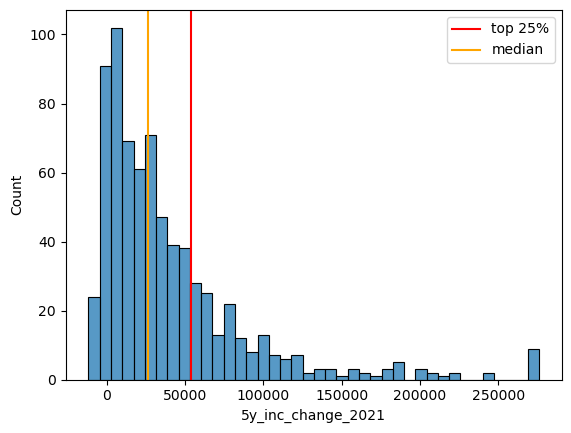

In [ ]:
sns.histplot(data=df_scaled['5y_inc_change_2021'],bins=40)
plt.axvline(np.percentile(df_target['5y_inc_change_2021'], 75),color='red',label='top 25%')
plt.axvline(df_scaled['5y_inc_change_2021'].median(),color='orange',label='median')
plt.legend()

In [ ]:
np.percentile(df_target['5y_inc_change_2021'], 75)


53715.98

In [ ]:
#Columns we are creating: 2015_class_a & 2021_class_a
for col in col_names(df_target,'change'):
    col_name=col[-4:]+'_target_b'
    threshold_temp=np.percentile(df_target[col], 75)
    #median for equal class division
    df_target[col_name]=df_target[col].apply(lambda x: 1 if x>threshold_temp else 0)

target_di['target_b']='More or less than 75% percentile'

In [ ]:
df_target

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021,2015_target_a,2021_target_a,2015_target_b,2021_target_b
0,10100,2224.5,-3588.26,124255.31,0,1,0,1
1,10201,2644.5,-1441.80,6196.53,0,0,0,0
2,10202,1109.5,-4915.49,36773.86,0,1,0,0
3,10300,2830.0,-5463.22,61374.44,0,1,0,1
4,10400,1940.5,-4284.07,7741.24,0,0,0,0
...,...,...,...,...,...,...,...,...
720,843700,964.5,12229.37,162555.85,1,1,1,1
721,843800,612.5,191.90,-5051.69,0,0,0,0
722,843900,1890.0,-4970.58,139855.94,0,1,0,1
723,844600,601.5,-3996.26,276276.91,0,1,0,1


**3) 4 percentiles for a 4 class classification**

* Could we balance the classes out by considering 25% quarters?

In [ ]:
def four_class_split(sr):
    t_25=np.percentile(sr, 25)
    t_50=np.percentile(sr, 50)
    t_75=np.percentile(sr, 75)
    result=[]
    for x in sr:
        if x<t_25:
            result.append(0)
        elif x<t_50:
            result.append(1)
        elif x<t_75:
            result.append(2)
        else:
            result.append(3)
    return result
    

In [ ]:
#Columns we are creating: 2015_class_a & 2021_class_a
for col in col_names(df_target,'change'):
    col_name=col[-4:]+'_target_c'

    #median for equal class division
    df_target[col_name]=four_class_split(df_target[col])

target_di['target_c']='4 class split, 25 percentile each'

In [ ]:
df_target

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021,2015_target_a,2021_target_a,2015_target_b,2021_target_b,2015_target_c,2021_target_c
0,10100,2224.5,-3588.26,124255.31,0,1,0,1,0,3
1,10201,2644.5,-1441.80,6196.53,0,0,0,0,1,0
2,10202,1109.5,-4915.49,36773.86,0,1,0,0,0,2
3,10300,2830.0,-5463.22,61374.44,0,1,0,1,0,3
4,10400,1940.5,-4284.07,7741.24,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
720,843700,964.5,12229.37,162555.85,1,1,1,1,3,3
721,843800,612.5,191.90,-5051.69,0,0,0,0,1,0
722,843900,1890.0,-4970.58,139855.94,0,1,0,1,0,3
723,844600,601.5,-3996.26,276276.91,0,1,0,1,0,3


**4) Percentage difference from the mean for linear regression**

In [ ]:
#Columns we are creating: 2015_class_a & 2021_class_a
for col in col_names(df_target,'change'):
    col_name=col[-4:]+'_target_d'

    mean_temp=df_target[col].median()
    #median for equal class division
    df_target[col_name]=df_target[col].apply(lambda x: round(x/mean_temp,4))

target_di['target_d']='percentage difference from the median'

In [ ]:
df_target

,Census_Tract,Household_Count,5y_inc_change_2015,5y_inc_change_2021,2015_target_a,2021_target_a,2015_target_b,2021_target_b,2015_target_c,2021_target_c,2015_target_d,2021_target_d
0,10100,2224.5,-3588.26,124255.31,0,1,0,1,0,3,-3.4737,4.7419
1,10201,2644.5,-1441.80,6196.53,0,0,0,0,1,0,-1.3958,0.2365
2,10202,1109.5,-4915.49,36773.86,0,1,0,0,0,2,-4.7585,1.4034
3,10300,2830.0,-5463.22,61374.44,0,1,0,1,0,3,-5.2887,2.3422
4,10400,1940.5,-4284.07,7741.24,0,0,0,0,0,1,-4.1473,0.2954
...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,964.5,12229.37,162555.85,1,1,1,1,3,3,11.8388,6.2035
721,843800,612.5,191.90,-5051.69,0,0,0,0,1,0,0.1858,-0.1928
722,843900,1890.0,-4970.58,139855.94,0,1,0,1,0,3,-4.8118,5.3373
723,844600,601.5,-3996.26,276276.91,0,1,0,1,0,3,-3.8686,10.5434


In [ ]:
fig = px.scatter_mapbox(coord(df_target), lat="LATITUDE", lon="LONGITUDE", color="2015_target_c", size="Household_Count", size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

In [ ]:
df_target.to_csv('../data/interim/income_cleaned.csv')

* [ ] Bring back the starting values for 2010 and 2015 
* [ ] Bring back the 10 year difference
* [ ] Consider if any other demographic data can be used
* [ ] 

***
*<center><h3>Extra WIP<center><h3>*